# P3

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [45]:
import pandas as pd
import numpy as np
import networkx as nx

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 1

## 1.1] Replicate Table 3 for the Reddit data

### 1.1.1]Load the Reddit data and do some basic analysis

**Load the data**

In [51]:
DATAFOLDER = '/content/drive/MyDrive/ADA - dataset/'
reddit_data_body_file = DATAFOLDER + 'soc-redditHyperlinks-body.tsv'
reddit_data_title_file = DATAFOLDER + 'soc-redditHyperlinks-title.tsv'
wikipedia_file = DATAFOLDER + 'wikiElec.ElecBs3.txt'


data_body = pd.read_csv(reddit_data_body_file, sep = '\t')
data_title = pd.read_csv(reddit_data_title_file, sep = '\t')
data_body.head(2)

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."


We rename the sign column, to have consistency with datasets like wikipedia, slashdot, epinions

In [52]:
data_body = data_body.rename(columns = {'LINK_SENTIMENT' : 'Sign'})
data_title = data_title.rename(columns = {'LINK_SENTIMENT' : 'Sign'})
data_body.head(10)

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."
5,dogemarket,dogecoin,1u4w7bs,2013-12-31 18:35:44,1,"1328.0,1110.0,0.768825301205,0.0143072289157,0..."
6,locationbot,legaladvice,1u4wfes,2014-01-07 20:17:41,1,"184.0,172.0,0.744565217391,0.0326086956522,0.0..."
7,indiefied,aww,1u50pos,2014-03-03 17:00:35,1,"295.0,256.0,0.749152542373,0.0203389830508,0.0..."
8,posthardcore,bestof2013,1u5ccus,2013-12-31 23:16:20,1,"3927.0,3488.0,0.719887955182,0.0229182582124,0..."
9,posthardcore,corejerk,1u5ccus,2013-12-31 23:16:20,1,"3927.0,3488.0,0.719887955182,0.0229182582124,0..."


**Create the dataframe containing body + title links**

In [53]:
data_total = pd.concat([data_body,data_title], ignore_index = True)
data_total.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


**Convert the names into ids**

In [ ]:
from gensim.corpora import Dictionary

unique_subreddits = [[element] for element in list(pd.concat([data_total['SOURCE_SUBREDDIT'], data_total['TARGET_SUBREDDIT']]).sort_values().unique())]
dct = Dictionary(unique_subreddits)

data_total['FromNodeId'] = dct.doc2idx(data_total['SOURCE_SUBREDDIT'].values)
data_total['ToNodeId'] = dct.doc2idx(data_total['TARGET_SUBREDDIT'].values)

In [ ]:
test = data_body[data_body['SOURCE_SUBREDDIT'] == 'leagueoflegends']
test[test['TARGET_SUBREDDIT'] == 'leagueoflegendsmeta']

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
311,leagueoflegends,leagueoflegendsmeta,1ue5u4s,2014-01-04 07:15:08,1,"705.0,604.0,0.756028368794,0.00567375886525,0...."
27785,leagueoflegends,leagueoflegendsmeta,28luias,2014-06-19 20:03:26,1,"1763.0,1431.0,0.667612024957,0.0328984685196,0..."
78113,leagueoflegends,leagueoflegendsmeta,2ygs2ns,2015-03-09 12:18:40,1,"1963.0,1643.0,0.792154865003,0.00254712175242,..."
108915,leagueoflegends,leagueoflegendsmeta,3d3lkls,2015-07-13 00:32:14,1,"4002.0,3336.0,0.755872063968,0.0114942528736,0..."
136923,leagueoflegends,leagueoflegendsmeta,3qzyi1s,2015-10-31 20:19:30,1,"1809.0,1512.0,0.782752902156,0.00110558319514,..."


In [ ]:

np.count_nonzero(data_body[data_body['SOURCE_SUBREDDIT'] == 'leagueoflegends']['TARGET_SUBREDDIT'].values == 'leagueoflegendsmeta')

5

**Count the number of nodes and edges**

In [ ]:
table = pd.DataFrame(columns = ['body', 'title', 'total'], index = ['Nodes', 'Edges', '+ edges', '- edges'])

nb_edges_body = data_body.shape[0]
nb_nodes_body = np.unique(np.concatenate((data_body['SOURCE_SUBREDDIT'].values , data_body['TARGET_SUBREDDIT'].values))).shape[0]

nb_edges_title = data_title.shape[0]
nb_nodes_title = np.unique(np.concatenate((data_title['SOURCE_SUBREDDIT'].values , data_title['TARGET_SUBREDDIT'].values))).shape[0]

nb_edges_total = data_total.shape[0]
nb_nodes_total = np.unique(np.concatenate((data_total['SOURCE_SUBREDDIT'].values , data_total['TARGET_SUBREDDIT'].values))).shape[0]


table.loc['Nodes'] = [nb_nodes_body, nb_nodes_title, nb_nodes_total]
table.loc['Edges'] = [nb_edges_body, nb_edges_title, nb_edges_total]

table.head()

,body,title,total
Nodes,35776,54075,67180
Edges,286561,571927,858488
+ edges,NaN,NaN,NaN
- edges,NaN,NaN,NaN


**Count the proportion of positives and negative edges**

To apply this to several datasets, we create a function

In [ ]:
#Number of positive (negative) edges :
#We first filter the data by keeping only +1 (or -1) values and then we find the number of lines (edges) that this filtering gives
nb_pos_edges_body = data_body[data_body['Sign']==1].shape[0] 
nb_neg_edges_body = data_body[data_body['Sign']==-1].shape[0]

nb_pos_edges_title = data_title[data_title['Sign']==1].shape[0] 
nb_neg_edges_title= data_title[data_title['Sign']==-1].shape[0]

nb_pos_edges_total = data_total[data_total['Sign']==1].shape[0] 
nb_neg_edges_total = data_total[data_total['Sign']==-1].shape[0]

#Proportion of positive/negative edges:
#We divide the number of positive (or negative) edges previouly found and divide it by the total number of edges
#We use the table1 to find the total number of edges as we already filled these informations
perc_pos_body = nb_pos_edges_body / table.loc['Edges']['body']
perc_neg_body = nb_neg_edges_body / table.loc['Edges']['body']

perc_pos_title = nb_pos_edges_title / table.loc['Edges']['title']
perc_neg_title = nb_neg_edges_title / table.loc['Edges']['title']

perc_pos_total = nb_pos_edges_total / table.loc['Edges']['total']
perc_neg_total = nb_neg_edges_total / table.loc['Edges']['total']

In [ ]:
#We must indicate a percentage format : we use the {:.1%} format to have a percentage with only one decimal, as in the paper 
table.loc['+ edges'] = ['{:.1%}'.format(perc_pos_body), '{:.1%}'.format(perc_pos_title), '{:.1%}'.format(perc_pos_total)]
table.loc['- edges'] = ['{:.1%}'.format(perc_neg_body), '{:.1%}'.format(perc_neg_title), '{:.1%}'.format(perc_neg_total)]

table.head()

,body,title,total
Nodes,35776,54075,67180
Edges,286561,571927,858488
+ edges,92.6%,89.3%,90.4%
- edges,7.4%,10.7%,9.6%


In the following, we take the total dataframe.

### 1.1.2] Replicate table 3

**Create the graph with networkx**

In [ ]:
from table3 import create_table3

table3_reddit = create_table3(data_total, data_type = 'reddit')

In [ ]:
table3_reddit.head()

,Triad Ti,|Ti|,p(Ti),p0(Ti),s(Ti)
0,T3 +++,1644323,0.863557,0.895420,-143.680338
1,T1 +--,41431,0.021759,0.009851,166.372390
2,T2 ++-,209148,0.109839,0.093704,76.401376
3,T1 ---,9225,0.004845,0.001024,164.806020


## 1.2] Study the impact of the proportion of positive edge on the table 3

By studying the results of this change on table 3, we can study how the proportion of positive edges impact the balance theory.

### 1.2.1] Remove some lines with positive link to have a dataset with 70% of positive edges

In [ ]:
data_remove = pd.concat((data_total[data_total['Sign']==-1], data_total[data_total['Sign']==1].sample(frac = 1).head(192000)))

nb_edges_remove = data_remove.shape[0]
nb_nodes_remove = np.unique(np.concatenate((data_remove['SOURCE_SUBREDDIT'].values , data_remove['TARGET_SUBREDDIT'].values))).shape[0]

nb_pos_edges_remove = data_remove[data_remove['Sign']==1].shape[0] 
nb_neg_edges_remove = data_remove[data_remove['Sign']==-1].shape[0]

perc_pos_remove = nb_pos_edges_remove / nb_edges_remove
perc_neg_remove = nb_neg_edges_remove / nb_edges_remove

table['remove_70'] = [nb_nodes_remove, nb_edges_remove, '{:.1%}'.format(perc_pos_remove), '{:.1%}'.format(perc_neg_remove)]
table.head()

,body,title,total,remove
Nodes,35776,54075,67180,40375
Edges,286561,571927,858488,274152
+ edges,92.6%,89.3%,90.4%,70.0%
- edges,7.4%,10.7%,9.6%,30.0%


**Create table 3 for this dataset, after removal of some positive edges**

In [ ]:
from table3 import create_table3

table3_reddit = create_table3(data_remove, data_type = 'reddit')

In [ ]:
table3_reddit.head()

,Triad Ti,|Ti|,p(Ti),p0(Ti),s(Ti)
0,T3 +++,323566,0.823078,0.591102,295.845970
1,T1 +--,10727,0.027287,0.108622,-163.888680
2,T2 ++-,56703,0.144240,0.253402,-157.356572
3,T1 ---,2121,0.005395,0.046874,-123.039876


### 1.2.2] Remove some lines with positive link to have a dataset with 50% of positive edges

In [ ]:
data_remove = pd.concat((data_total[data_total['Sign']==-1], data_total[data_total['Sign']==1].sample(frac = 1).head(82000)))

nb_edges_remove = data_remove.shape[0]
nb_nodes_remove = np.unique(np.concatenate((data_remove['SOURCE_SUBREDDIT'].values , data_remove['TARGET_SUBREDDIT'].values))).shape[0]

nb_pos_edges_remove = data_remove[data_remove['Sign']==1].shape[0] 
nb_neg_edges_remove = data_remove[data_remove['Sign']==-1].shape[0]

perc_pos_remove = nb_pos_edges_remove / nb_edges_remove
perc_neg_remove = nb_neg_edges_remove / nb_edges_remove

table['remove_50'] = [nb_nodes_remove, nb_edges_remove, '{:.1%}'.format(perc_pos_remove), '{:.1%}'.format(perc_neg_remove)]
table.head()

,body,title,total,remove,remove_50
Nodes,35776,54075,67180,40375,31507
Edges,286561,571927,858488,274152,164152
+ edges,92.6%,89.3%,90.4%,70.0%,50.0%
- edges,7.4%,10.7%,9.6%,30.0%,50.0%


In [ ]:
table3_reddit = create_table3(data_remove, data_type = 'reddit')
table3_reddit.head()

,Triad Ti,|Ti|,p(Ti),p0(Ti),s(Ti)
0,T3 +++,92894,0.608858,0.589994,14.980611
1,T1 +--,15752,0.103244,0.108608,-6.733679
2,T2 ++-,36952,0.242195,0.254555,-11.082951
3,T1 ---,6973,0.045703,0.046842,-2.105825


## 1.3] Study of reciprocated links

This part consist in replicating table 4 for the reddit data to enforce or refute the conclusion the authors do about reciprocated edges : balance theory is good to predict the sign of the reciprocated link of a positive link, and status explains well the sign of the reciprocated link of a negative link. 

We first replicate the table 4 for the wikipedia dataset to prove that our process is correct, and to ensure the reproducibility of this part of the paper.

### 1.3.1] Reciprocation of table 4 for the wikipedia dataset

**Load the wikipedia data and remove its neutral links**

We use the parsed file we created in P2.

In [ ]:
wiki_data = pd.read_csv('wiki_parsed.txt', sep = '\t', header = None) #we load the data
wiki = wiki_data.rename(columns={0: "FromNodeId", 1 : "ToNodeId", 2 : "Sign"}) #renamethe columns
neutral_indx = wiki[wiki.Sign==0].index.values #We filter the dataset to keep neutral links and find the values of the indexes
wiki = wiki.drop(neutral_indx) #We drop these lines

In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(wiki, 'FromNodeId', 'ToNodeId', edge_attr = 'Sign')

In [ ]:
L = []
for node in G.nodes():
    neighbors = G[node]
    for neighbor in neighbors:
        if node in G[neighbor]:
            L.append((node, neighbor))

In [ ]:
len(L)

201582

**Create a dataframe that contains only reciprocated edges**

Notation : if A links towards B, we name A as the starting node, and B as the target node.<br>
Let A links towards B, a simple description of our strategy  to find if B links to A is to find all edges that have B as a starting node. If A is a part of the target nodes of B, then B links to A. We create a dataframe for which we only include reciprocated edges, we add both the edges from A to B, and from B to A.

The detailed code strategy to find reciprocated edges is : 
- Initialization : create a dataframe that will contain the edges for which we have a reciprocation.
- 1st loop : we loop over all starting nodes, namely we loop over each `from_node`. For each `from_node`, we filter the original dataset to only have edges that have `from_node` as starting node.
- 2nd loop : we loop over each target node of `from_node`. For each of these `to_node`, we filter the dataset to have edges that starts from `to_node`.
- Test assignement : if `from_node` is a part of the target node of `to_node`, then we add the edges. Sometimes there is the same edge several times : we have $A \rightarrow B$ several times. We decide to only have each edge one time : we just include $A \rightarrow B$ one time and $B \rightarrow A$ one time.

In [ ]:
#Initialization
wiki_reci = pd.DataFrame()

#1st loop : #for all starting nodes
for from_node in wiki['FromNodeId'].unique(): 
    #filter the dataset to have only the edges that have from_node as a starting node
    from_df = wiki[wiki['FromNodeId'] == from_node]
    
    #2nd loop : for each target node for 'from_node', the starting node 
    for to_node in from_df['ToNodeId'].values : 
        #filter the dataset to have the edges that have as starting node, the target node of 'from_node'
        to_df = wiki[wiki['FromNodeId'] == to_node] 
        
        if from_node in to_df['ToNodeId'].values: #
            #we add both edges
            wiki_reci = pd.concat([wiki_reci, wiki.loc[(wiki['FromNodeId'] ==from_node) & (wiki['ToNodeId']==to_node)].head(1)])
            wiki_reci = pd.concat([wiki_reci, wiki.loc[(wiki['FromNodeId'] == to_node) & (wiki['ToNodeId']==from_node)].head(1)])
            #we need to drop at least one edge from the original data to not add the reciprocation several times
            wiki = wiki.drop(wiki.loc[(wiki['FromNodeId'] ==from_node) & (wiki['ToNodeId']==to_node)].index)
            wiki = wiki.drop(wiki.loc[(wiki['FromNodeId'] ==to_node) & (wiki['ToNodeId']==from_node)].index)
            
wiki_reci.head() #2min30

,FromNodeId,ToNodeId,Sign
33,3,54,1
1157,54,3,1
720,3,28,1
1180,28,3,1
2144,3,178,1


In [ ]:
wiki_reci.shape[0]

We first want to know what part of the original wikipedia reciprocated edges represent. The authors say that about 3-5% of the original dataset's edges are reciprocation of existing links. 

To check this, we divide the number of edges of this dataframe containing reciprocated edges by two time the number of edges in the original dataset (because we counted the link and its reciprocation, while in the paper they only count the reciprocation).

In [ ]:
#we compute the proportion
print('propotion of reciprocated edges : {:.2%}'.format(wiki_reci.shape[0]/(2*wiki.shape[0])))

propotion of reciprocated edges : 2.96%


It seems we have a similar result than with the paper. Now we replicate table 4

**Replication of table 4 for the wikipedia dataset**

To do this, we first create the networkx graph associated with this dataframe. Then we replicate table 4. The idea to find the `P(+|+)` and `P(-|+)` is the following : for each node, we find each of its neighbors linked with a positive sign to it, and then we test what is the sign of the reciprocated link, and add a count to the corresponding field.

In [ ]:
from table4 import create_table4

table4_wiki = create_table4(wiki_reci, name_data = 'wikipedia')
table4_wiki.head()

,wikipedia,Count,Fraction
0,P(+|+),2542,0.950636
1,P(-|+),132,0.049364
2,P(+|-),206,0.662379
3,P(-|-),105,0.337621


Here is the table 4 from the paper :
>![image.png](attachment:efcb5830-fd78-4266-b9b0-a7c11f80fc6a.png)

Our results are not the exact same, but are very close to the ones in the paper. We conclude on a good replication power of the paper for this table. We use the same process for the reddit data.

### 1.3.2] Replication of table 4 for the reddit dataset

We basically copy the functions from before, but with the reddit data

**Create a dataframe that contains only reciprocated edges**

We use the exact same code as before, but his time we use the reddit dataset.

In [ ]:
reddit = data_total

reddit_reci = pd.DataFrame()
for from_node in reddit['FromNodeId'].unique(): #for all unique nodes
    #filter the dataset to have only the edges that have from_node as a starting node
    from_df = reddit[reddit['FromNodeId'] == from_node]
    for to_node in from_df['ToNodeId'].values : #for all target node of 'from_node'
        to_df = reddit[reddit['FromNodeId'] == to_node]
        if from_node in to_df['ToNodeId'].values:
            #we add both edges
            reddit_reci = pd.concat([reddit_reci, reddit.loc[(reddit['FromNodeId'] ==from_node) & (reddit['ToNodeId']==to_node)].head(1)])
            reddit_reci = pd.concat([reddit_reci, reddit.loc[(reddit['FromNodeId'] == to_node) & (reddit['ToNodeId']==from_node)].head(1)])
            #we need to drop at least one edge from the original data to not add the reciprocation several times
            reddit = reddit.drop(reddit.loc[(reddit['FromNodeId'] ==from_node) & (reddit['ToNodeId']==to_node)].index)
            reddit = reddit.drop(reddit.loc[(reddit['FromNodeId'] ==to_node) & (reddit['ToNodeId']==from_node)].index)
            
reddit_reci.head() 

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES,FromNodeId,ToNodeId
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08...",32023,57105
6172,teamredditteams,leagueoflegends,1xoxyes,2014-02-11 23:07:12,1,"288.0,252.0,0.774305555556,0.00694444444444,0....",57105,32023
311,leagueoflegends,leagueoflegendsmeta,1ue5u4s,2014-01-04 07:15:08,1,"705.0,604.0,0.756028368794,0.00567375886525,0....",32023,32026
4196,leagueoflegendsmeta,leagueoflegends,1wl2hzs,2014-01-30 12:32:16,1,"1117.0,928.0,0.761862130707,0.000895255147717,...",32026,32023
320,leagueoflegends,iama,1ueax1s,2014-01-04 08:32:51,1,"110.0,110.0,0.763636363636,0.0363636363636,0.0...",32023,27319


This operation took a very long time (hours), so i save it into a csv file to not running it again if needed.

In [ ]:
#save it into a csv file
reddit_reci.to_csv('reddit_reciprocation.csv')

In [ ]:
#If we saved the csv file, we can load it :
reddit_reci = pd.read_csv('reddit_reciprocation.csv')

In [ ]:
#we compute the proportion
print('propotion of reciprocated edges : {:.2%}'.format(reddit_reci.shape[0]/(2*reddit.shape[0])))

propotion of reciprocated edges : 5.38%


The proportion of the original dataset to be reciprocated edges is higher than for the wikipedia dataset.

**Replication of table 4**

In [ ]:
from table4 import create_table4

table4_reddit = create_table4(reddit_reci, name_data = 'reddit')
table4_reddit.head()

,reddit,Count,Fraction
0,P(+|+),27002,0.954505
1,P(-|+),1287,0.045495
2,P(+|-),1482,0.878483
3,P(-|-),205,0.121517


The results seems to be consistent with the conclusion authors make : if A-B is positive, we have in 95.4% of cases that B-A is positive as well, which is higher than the 90% os positive links in the data. So balance theory explains well the proportion of $P(+|+)$, as a reciprocation of a positive link should be positive as well. 

Plus, if A-B is negative, B-A is positive in 87.8% of cases. Which is (a bit) lower than the 90% of positive edges. Therefore we say that status theory explains well the high proportion of $P(+|-)$, as if A links negatively to B (A thinks B has a ower status), then B should link positively to A (B thinks A has a higher status). 

**By curiosity, we can see several examples of links that satisfies $P(-|+)$, $P(+|-)$ and $P(-|-)$**

In [ ]:
#Examples of links satisfying P(-|+)
from table4 import print_p2

print_p2(reddit_reci, name_data = 'reddit', nb_ex = 10)

Examples of subreddits (A,B) satisfying P(-|+) : A link positive to B, B link negative to A 
example 1 :
A : leagueoflegends
B : gaming

example 2 :
A : leagueoflegends
B : leagueofmemes

example 3 :
A : nfl
B : chibears

example 4 :
A : nfl
B : detroitlions

example 5 :
A : nfl
B : steelers

example 6 :
A : nfl
B : showerthoughts

example 7 :
A : dogemarket
B : dogecoinscamwatch

example 8 :
A : metalcore
B : music

example 9 :
A : suicidewatch
B : needadvice

example 10 :
A : suicidewatch
B : mensrights



In [ ]:
#Examples of links satisfying P(+|-)
from table4 import print_p3

print_p3(reddit_reci, name_data = 'reddit', nb_ex = 4)

Examples of subreddits (A,B) satisfying P(+|-) : A link negative to B, B link positive to A 
example 1 :
A : leagueoflegends
B : cringepics

example 2 :
A : leagueoflegends
B : gameofthrones

example 3 :
A : leagueoflegends
B : todayilearned

example 4 :
A : leagueoflegends
B : caitlynmains



In [ ]:
#Examples of links satisfying P(-|-)
from table4 import print_p4

print_p4(reddit_reci, name_data = 'reddit', nb_ex = 4)

Examples of subreddits (A,B) satisfying P(-|-) : A link negative to B, B link positive to A 
example 1 :
A : leagueoflegends
B : bestof

example 2 :
A : leagueoflegends
B : dotamasterrace

example 3 :
A : suicidewatch
B : bestof

example 4 :
A : circlebroke
B : shitredditsays



# Analysis of Time 

## Analyzing the global trend 

**NOTE FOR PART 2** : On the following analysis we will only consider the body dataset from reddit. As we will use sentiment score, it seams more relevant to use the one computed from a text than from a single title as it will be more nuanced and thus will represent better the overall idea of the post. 

## Global pathway of the analysis --------------------------------------------------------------------------- 

1) Work on the Reddit dataset
- step 0 : work with Date data
- step 1 : analysis of the year 
- step 2 : analysis of the month 
- step 3 : analysis of the day of the month and of the week 
- step 4 : analyis of the hour 

Aim : identify the main trends among the time data, and thus define new subgraphs

2) Do the structural analysis of these subgraphs 
Parameters : Centrality, Clustering, Behavior
3) First conclusion

4) Work on the wikipedia and slashdot dataset
- same steps 0, 1, 2, 3, 4
Aim : identify the main trends among the time data, and thus define new subgraphs

5) Do the structural analysis of these second subgraphs 
Parameters : Centrality, Clustering, Behavior

6) Second Conclusion

7) Draw the scheme of a situation, to illustrate how the time can influence the formation of new edges compared to status and balance theory. (Abstract, with a drawing)

## -----------------------------------------------------------------------------------------------------------------------------

## 1) Work on the Reddit dataset
### **Step 0**  : Work with datetime data

## 1) Work on the Reddit dataset
### **Step 0**  : Work with datetime data

In [ ]:
print('Exemple : the date of the first post of the dataset is : {}'.format(data_body['TIMESTAMP'][3]))
print(' Its type is ',type(data_body['TIMESTAMP'][3]))

Exemple : the date of the first post of the dataset is : 2013-12-31 17:37:55
 Its type is  <class 'str'>


Here the date are strings, so we need to convert them into datetime form as we want to do time manipulation (e.g. year example). 

In [47]:
# Useful libraries 
from datetime import datetime, date, time
import calendar 

In [ ]:
# create the new column in the dataframe
#data_body['DATETIME'] = 0.0
#data_body.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES,DATETIME
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08...",0.0
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049...",0.0
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082...",0.0
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0....",0.0
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0....",0.0


In [54]:
data_body['TIMESTAMP'] = pd.to_datetime(data_body['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [55]:
data_body.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


In [56]:
print(type(data_body['TIMESTAMP'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


**Split the dataset into positive and negative edges**

*Positif*

In [57]:
body_pos = data_body.copy()
body_pos = body_pos.drop(body_pos[body_pos.Sign == -1.0].index).reset_index(drop=True)
print('data body original .{}'.format(data_body.shape))
print('body POS {}'.format(body_pos.shape))

data body original .(286561, 6)
body POS (265491, 6)


In [58]:
print('In data body : sign of post 4 = ', data_body.iloc[1][4])
print('In body pos : sign of post 4 = ', body_pos.iloc[1][4])

In data body : sign of post 4 =  -1
In body pos : sign of post 4 =  1


In [59]:
body_pos.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
2,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
3,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."
4,dogemarket,dogecoin,1u4w7bs,2013-12-31 18:35:44,1,"1328.0,1110.0,0.768825301205,0.0143072289157,0..."


*Negatif*

In [33]:
body_neg = data_body.copy()
body_neg= body_neg.drop(body_neg[body_neg.Sign == 1.0].index).reset_index(drop=True)
print('data body original .{}'.format(data_body.shape))
print('body NEG {}'.format(body_neg.shape))

data body original .(286561, 8)
body NEG (21070, 8)


In [60]:
print('In data body : sign of post 4 = ', data_body.iloc[0][4])
print('In body pos : sign of post 4 = ', body_neg.iloc[0][4])

In data body : sign of post 4 =  1
In body pos : sign of post 4 =  -1


In [61]:
body_neg.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES,DATETIME2,DATETIME
0,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049...",2013-12-31 18:18:37,2013-12-31 18:18:37
1,karmaconspiracy,funny,1u6fz3,2014-01-01 12:44:19,-1,"186.0,182.0,0.741935483871,0.0376344086022,0.0...",2014-01-01 12:44:19,2014-01-01 12:44:19
2,badkarma,gamesell,1u6t4g,2014-01-01 16:42:14,-1,"262.0,258.0,0.725190839695,0.0381679389313,0.0...",2014-01-01 16:42:14,2014-01-01 16:42:14
3,casualiama,teenagers,1u70s8,2014-01-01 17:09:46,-1,"91.0,91.0,0.78021978022,0.032967032967,0.04395...",2014-01-01 17:09:46,2014-01-01 17:09:46
4,australia,sydney,1u71zd,2014-01-01 17:24:46,-1,"2547.0,2158.0,0.801334903808,0.0051040439733,0...",2014-01-01 17:24:46,2014-01-01 17:24:46


### Step 1 : Analysis of the year

In [68]:
import matplotlib.pyplot as plt

In [69]:
# verify the type of data time 
print(type(data_body.TIMESTAMP [0]))
print(type(body_pos.TIMESTAMP [0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [70]:
# Just to have an idea of what it'll look like. 
year_positive = body_pos.groupby(data_body['TIMESTAMP'].dt.year).size()
year_negative = body_neg.groupby(data_body['TIMESTAMP'].dt.year).size()

print('Year Positive', year_positive)
print('Year Negative', year_negative)

Year Positive TIMESTAMP
2013        7
2014    63342
2015    88572
2016    98167
2017    15403
dtype: int64
Year Negative TIMESTAMP
2013        7
2014    21038
2015       20
2016        4
2017        1
dtype: int64


So there are 5 years presented in the dataset : 2013, 2014, 2015, 2016 and 2017. 

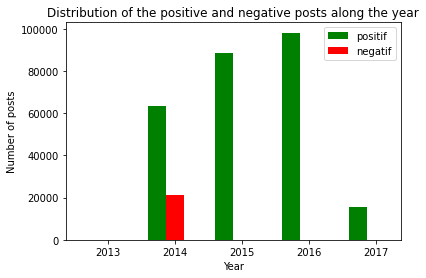

In [71]:
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

 
year_pos = body_pos.groupby(data_body['TIMESTAMP'].dt.year).size()
rects1 = ax.bar(ind, year_pos, width, color='g')
year_neg = body_neg.groupby(data_body['TIMESTAMP'].dt.year).size()

rects2 = ax.bar(ind+width, year_neg, width, color='r')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Year')
ax.set_title('Distribution of the positive and negative posts along the year')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('2013', '2014', '2015', '2016', '2017') )
ax.legend( (rects1[0], rects2[0]), ('positif', 'negatif') )

plt.show()

**Analysis :** 
- the number of post in 2013 is inexistant on the graph

In [72]:
print('The number of positive posts in 2013 is ', year_pos.iloc[0])
print('The number of negative posts in 2013 is ', year_neg.iloc[0])
print('So the total number of posts in 2013 is {} while in 2016 it is {}'.format(year_pos.iloc[0]+year_neg.iloc[0], vals_pos.iloc[3]+year_neg.iloc[3]))

print('The number of positive posts in 2015 is {}, in 2016 is {} and in 2017 is {}'.format(year_neg.iloc[2], year_neg.iloc[3], year_neg.iloc[4]))

The number of positive posts in 2013 is  7
The number of negative posts in 2013 is  7


NameError: ignored

- As we can see here, it might come from a problem of scale, as sometimes even if the amount of post is not null, no bar appear.The total amount of posts (positive and negative) during 2013 is very very small compared to the number of posts 2016. It is the same for the 2015 2016 and 2017 for the negative posts that don't appear, even if when we are calling the numbers they do exists. Their value is too small compared to the value of negative posts in 2014 to be seen on a graph, even when plotted alone. The small amount of posts in 2013 could be explained by the gain of popularity of the website, or the change in behavior of the population (who is more and more connected via internet and social network, and have better access to technology). The big amount of negative votes might comes from an external events. 

- the brutal decrease in 2017 in both positive and negative edges might be explained by loose of popularity, or the apparition of another website more performant than reddit. 

To be able to identify the trend among the year, we compute the ratio of neg/pos*100. 

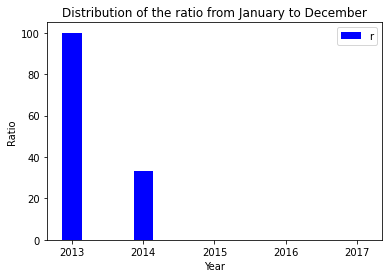

In [73]:
ratio = [(int(b) / int(m))*100 for b,m in zip(year_neg, year_pos)]
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)


rects1 = ax.bar(ind, ratio, width, color='b')
ax.set_ylabel('Ratio')
ax.set_xlabel('Year')
ax.set_title('Distribution of the ratio from January to December')
ax.set_xticks(ind)
ax.set_xticklabels( ('2013', '2014', '2015', '2016', '2017'))
ax.legend('ratio neg/pos*100')

plt.show()

- So here we see 3 parts : 2013 (lot of negative votes), 2014 (almost 50% 50%) and 2015-2016-2017 (almost no negative votes. 
- As we are doing this in order to compare the structure of the subnetworks, it will be easier if the networks are really different. So between 2015 2016 and 2017 we will choose 2016 as it is the year with the higher amount of positive votes, the negatives ones being quite constant along these 3 years. 
- in 2013 as we have seen there are only 7 positive and 7 negatives votes. So it is too small network to do an analysis. 

**Ccl :** In order to assess the impact of the **YEAR** on the structure of the network, we can compare 2 subgraphs : 
> - from the year 2014
> - from the year 2016

### Step 2: Analysis of the month 

In [74]:
month_positive = body_pos.groupby(data_body['TIMESTAMP'].dt.month).size()
month_negative = body_neg.groupby(data_body['TIMESTAMP'].dt.month).size()
print('Month Positive', month_positive)
print('Month Negative', month_negative)

Month Positive TIMESTAMP
1     28143
2     25743
3     21491
4     20343
5     20469
6     21184
7     22312
8     23195
9     19522
10    21067
11    20528
12    21494
dtype: int64
Month Negative TIMESTAMP
1     4422
2     4425
3     5363
4     4980
5     1822
6        9
7       12
8        3
9        3
10       1
11      19
12      11
dtype: int64


So 12 months are represented : 01 ... 12 in the dataset. 

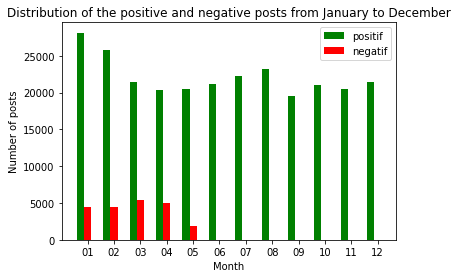

In [75]:
N = 12
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

 
month_pos = body_pos.groupby(data_body['TIMESTAMP'].dt.month).size()
rects1 = ax.bar(ind, month_pos, width, color='g')
month_neg = body_neg.groupby(data_body['TIMESTAMP'].dt.month).size()
rects2 = ax.bar(ind+width, month_neg, width, color='r')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Month')
ax.set_title('Distribution of the positive and negative posts from January to December')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'))
ax.legend( (rects1[0], rects2[0]), ('positif', 'negatif') )

plt.show()

**Analysis :**
- All the month do have posts
- The difference between the number of positive and negative posts is huge, all along the year and depsite intern fluctation
- The number of negative posts is higher at the beginning of the year (01-05) than at the end of the year (06-12)
- So we can identify to main part on the graph : when we have both green and red barplots (01-50) and when we don't have green and red. 
- Also we can identify 2 main values of counts : around 20 000 and around 25 000 
 

First compute the ration of positive and negative posts, to se if it is quite constant or not. 

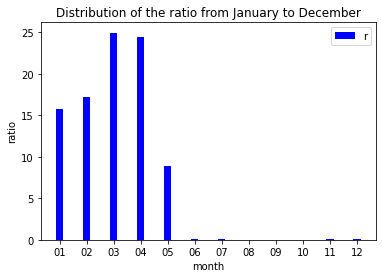

In [76]:
ratio = [(int(b) / int(m))*100 for b,m in zip(month_neg, month_pos)]
N = 12
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)


rects1 = ax.bar(ind, ratio, width, color='b')
ax.set_ylabel('ratio')
ax.set_xlabel('month')
ax.set_title('Distribution of the ratio from January to December')
ax.set_xticks(ind)
ax.set_xticklabels( ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'))
ax.legend('ratio neg/pos*100')

plt.show()

- So here we have 3 parts : 01-02-05 with ratio between 10 and 15, 03-04 with ratio around 25 and 06-->12 with ratio very very small. So we'll pick one month representing each of this part to continue the analysis. 

In [77]:
import statistics

In [78]:
# 01 - 02 - 05 
mean_010205_pos = statistics.mean([month_pos.iloc[0], month_pos.iloc[1], month_pos.iloc[4]])
print('The mean count of posts from jan. to apr. is ', mean_010205_pos)
print('The difference between number of counts and mean for january, february and may is respectively: \n',[abs(x - mean_010205_pos) for x in [month_pos.iloc[0], month_pos.iloc[1], month_pos.iloc[4]]])

The mean count of posts from jan. to apr. is  24785
The difference between number of counts and mean for january, february and may is respectively: 
 [3358, 958, 4316]


So we see that the average value of positive post between january, february and may is 24785. We also see that the month with the number of counts the closer to this mean is february (it as the small difference, 358) and thus the more representative.

In [79]:
# 03 - 04 
mean_0304_pos = statistics.mean([month_pos.iloc[2], month_pos.iloc[3]])
print('The mean count of posts from jan. to apr. is ', mean_0304_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_0304_pos) for x in [month_pos.iloc[2], month_pos.iloc[3]]])

The mean count of posts from jan. to apr. is  20917
The difference between number of counts and mean for march and april is respectively: 
 [574, 574]


So we see that the average number of positive counts between march and april is 20917. We also see that both are at equal distance to the mean. We will choose march because it has a high number of votes and thus might be more rich in the further analysis. 

In [80]:
# 06 - 12 
# 03 - 04 
mean_0612_pos = statistics.mean([month_pos.iloc[5], month_pos.iloc[6], month_pos.iloc[7], month_pos.iloc[8], month_pos.iloc[9], month_pos.iloc[10], month_pos.iloc[11]])
print('The mean count of posts from jan. to apr. is ', mean_0612_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_0612_pos) for x in [month_pos.iloc[5], month_pos.iloc[6], month_pos.iloc[7], month_pos.iloc[8], month_pos.iloc[9], month_pos.iloc[10], month_pos.iloc[11]]])


The mean count of posts from jan. to apr. is  21328
The difference between number of counts and mean for march and april is respectively: 
 [144, 984, 1867, 1806, 261, 800, 166]


So we see that the average number of positive edges between march and april is 21328. We also see that the month closer to this average is june (difference smaller, 144) and thus it is the more representative.

**Ccl :** In order to assess the impact of the **MONTH** on the structure of the network, we can compare 2 subgraphs : 
> - from february (representative of the first group - ratio 10 -)
> - from march (representative of the second group, -ratio 25-)
> - from june (representative of the third group, -ration almost null)

### Step 3: Analysis of the day

In [82]:
day_positive = body_pos.groupby(data_body['TIMESTAMP'].dt.day).size()
day_negative = body_neg.groupby(data_body['TIMESTAMP'].dt.day).size()
print('Month Positive', day_positive)
print('Month Negative', day_negative)

Month Positive TIMESTAMP
1     8535
2     9120
3     8966
4     8436
5     8690
6     8941
7     8561
8     8572
9     8645
10    8825
11    9029
12    8810
13    8715
14    8367
15    8887
16    9349
17    9153
18    8787
19    8666
20    9198
21    8516
22    8610
23    8393
24    8400
25    8424
26    8318
27    8778
28    8299
29    8217
30    8236
31    5048
dtype: int64
Month Negative TIMESTAMP
1     671
2     764
3     777
4     773
5     742
6     909
7     770
8     806
9     767
10    797
11    855
12    625
13    631
14    618
15    628
16    692
17    738
18    617
19    637
20    603
21    586
22    640
23    640
24    691
25    683
26    630
27    659
28    664
29    561
30    531
31    365
dtype: int64


So we see that all the 31 days of a month are represented in the dataset. 

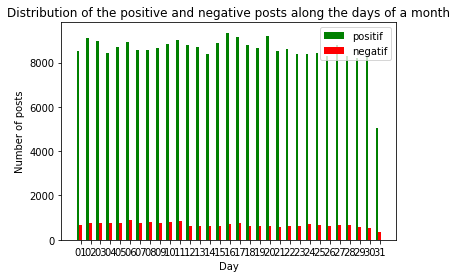

In [83]:
N = 31
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

 
day_pos = body_pos.groupby(data_body['TIMESTAMP'].dt.day).size()
rects1 = ax.bar(ind, day_pos, width, color='g')
day_neg = body_neg.groupby(data_body['TIMESTAMP'].dt.day).size()
rects2 = ax.bar(ind+width, day_neg, width, color='r')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Day')
ax.set_title('Distribution of the positive and negative posts along the days of a month')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26' ,'27', '28', '29', '30', '31'))
ax.legend((rects1[0], rects2[0]), ('positif', 'negatif'))

plt.show()

**Analysis :** 
- graph not very lisible (**Change the size ?**)
- the abrupt decrease for day 31 is because only half of the month in a year have a 31th day, so obviously there are less posts (pos and neg) done that day
- the amount of positive post is very small compared to amount of positif posts, for all the days 
- General manner : both positive and negative counts seams to be relatively constant along the days of a month, they are some fluctuations (more visible for positive posts) but it is hard to highlight clear trend. 

**Ccle :** We need to do further analysis on the days to be able to identify trends. So we are going to look at the number of posts according to the day of the weem: monday, tuesday ... sunday. 

Compute the ratio

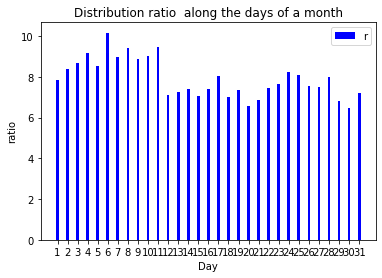

In [ ]:
ratio = [(int(b) / int(m))*100 for b,m in zip(day_neg, day_pos)]
N = 31
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, ratio, width, color='b')

ax.set_ylabel('ratio')
ax.set_xlabel('Day')
ax.set_title('Distribution ratio  along the days of a month')
ax.set_xticks(ind)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26' ,'27', '28', '29', '30', '31'))
ax.legend('ratio')
plt.show()

- still hard to identify a trend. Have to look on the day og the week to try to identify pattern

#### Step 3 : cont. Analysis day of the week

In [84]:
day_positive = body_pos.groupby(data_body['TIMESTAMP'].dt.weekday).size()
day_negative = body_neg.groupby(data_body['TIMESTAMP'].dt.weekday).size()
print('Month Positive', day_positive)
print('Month Negative', day_negative)

Month Positive TIMESTAMP
0    40390
1    40945
2    40052
3    39617
4    37373
5    32527
6    34587
dtype: int64
Month Negative TIMESTAMP
0    3101
1    3458
2    3145
3    3123
4    2956
5    2542
6    2745
dtype: int64


So the days reprensented in the dataset are from 0 (monday) to 6 (sunday). 

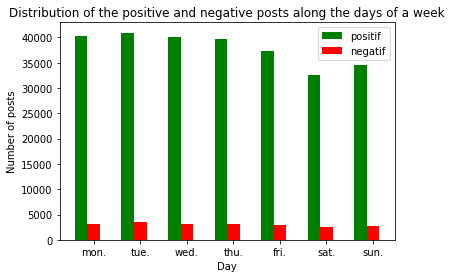

In [85]:
N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

 
dayw_pos = body_pos.groupby(data_body['TIMESTAMP'].dt.weekday).size()
rects1 = ax.bar(ind, dayw_pos, width, color='g')
dayw_neg = body_neg.groupby(data_body['TIMESTAMP'].dt.weekday).size()
rects2 = ax.bar(ind+width, dayw_neg, width, color='r')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Day')
ax.set_title('Distribution of the positive and negative posts along the days of a week')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('mon.', 'tue.', 'wed.', 'thu.', 'fri.', 'sat.', 'sun.'))
ax.legend((rects1[0], rects2[0]), ('positif', 'negatif'))

plt.show()

**Analysis :**
- As for the other parameter (year, month, day of the month), the amount of positive posts is higher than the amount of negative posts
- The amount of negative posts is quite constant along the week 
- the amount of positive posts is smaller the week end, and quite constant during the week. It might be explained by the routine of the week, so the habits of beeing on the website for coffe break for example, while the week end, the events are more random and technology connection can be smaller. 


Compute the ratio to ensure this analysis

[7.677642980935875, 8.445475638051043, 7.852292020373515, 7.882979528990081, 7.909453348674177, 7.815045961816337, 7.936507936507936]


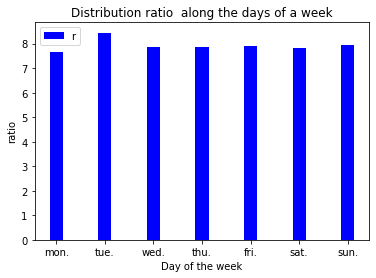

In [86]:
ratio = [(int(b) / int(m))*100 for b,m in zip(dayw_neg, dayw_pos)]
print(ratio)
N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, ratio, width, color='b')

ax.set_ylabel('ratio')
ax.set_xlabel('Day of the week')
ax.set_title('Distribution ratio  along the days of a week')
ax.set_xticks(ind)
ax.set_xticklabels( ('mon.', 'tue.', 'wed.', 'thu.', 'fri.', 'sat.', 'sun.'))
ax.legend('ratio')
plt.show()

- here we can see that in fact the ratio of positive and negative edge is quite the same all along the week 
- there is only in tuesday that the ratio is a bit bigger. 

**Ccl :** We can do analysis on the subset from tuesday, and one from another day of the week (ratio is similar) but as the difference is not very big, not sure we ll see something on the structure of the network.

We can also do subsets from the week and from the week, as the size of the pool of posts is not the same ???

#### Step 4: Analysis of the hour 

In [87]:
hour_positive = body_pos.groupby(data_body['TIMESTAMP'].dt.hour).size()
hour_negative = body_neg.groupby(data_body['TIMESTAMP'].dt.hour).size()
print('Month Positive', hour_positive)
print('Month Negative', hour_negative)

Month Positive TIMESTAMP
0      7089
1      6045
2      5634
3      6100
4      6867
5      7819
6      9938
7     12069
8     13372
9     14426
10    14189
11    14887
12    14571
13    14617
14    14994
15    14149
16    13267
17    13167
18    12418
19    11889
20    10925
21     9900
22     8934
23     8225
dtype: int64
Month Negative TIMESTAMP
0      423
1      378
2      368
3      331
4      433
5      509
6      835
7      830
8      983
9     1335
10    1167
11    1347
12    1232
13    1208
14    1345
15    1185
16    1091
17    1059
18    1025
19     961
20     892
21     816
22     757
23     560
dtype: int64


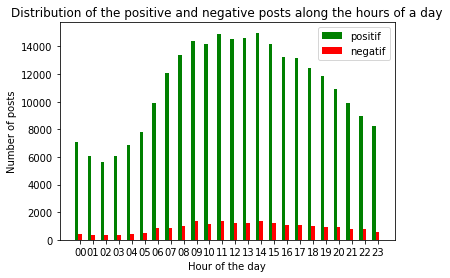

In [88]:
N = 24
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

hour_pos = body_pos.groupby(data_body['TIMESTAMP'].dt.hour).size()
rects1 = ax.bar(ind, hour_pos, width, color='g')
hour_neg = body_neg.groupby(data_body['TIMESTAMP'].dt.hour).size()
rects2 = ax.bar(ind+width, hour_neg, width, color='r')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Hour of the day')
ax.set_title('Distribution of the positive and negative posts along the hours of a day')
ax.set_xticks(ind+width)
ax.set_xticklabels(('00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))
ax.legend((rects1[0], rects2[0]), ('positif', 'negatif'))

plt.show()

**Analysis :**
- Seems to have smaller number of posts during night and a lot during the afternoon. Quite logical. Positive and negatives posts seams to have quite the same evolution, need to compute the ratio to show it more clearly.

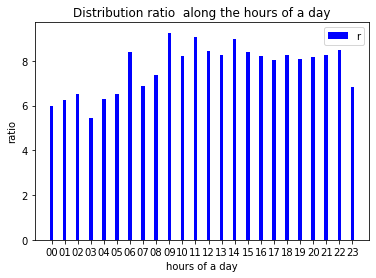

In [ ]:
ratio = [(int(b) / int(m))*100 for b,m in zip(hour_neg, hour_pos)]
N = 24
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, ratio, width, color='b')

ax.set_ylabel('ratio')
ax.set_xlabel('hours of a day')
ax.set_title('Distribution ratio  along the hours of a day')
ax.set_xticks(ind)
ax.set_xticklabels(('00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))
ax.legend('ratio')
plt.show()

- we can identify three part : low ration (5-7) for 00, 01, 02, 03, 04, 05, 07, 23 ; middle ratio (8) for 06, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22 and high ratio (9) for 09, 11 and 14

- need to find a relevent hour for each of these parts


In [ ]:
# ratio 5-7 
mean_r57_pos = statistics.mean([hour_pos.iloc[0], hour_pos.iloc[1], hour_pos.iloc[2], hour_pos.iloc[3], hour_pos.iloc[4], hour_pos.iloc[5], hour_pos.iloc[7], hour_pos.iloc[23]])
print('The mean count of posts from jan. to apr. is ', mean_r57_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_r57_pos) for x in[hour_pos.iloc[0], hour_pos.iloc[1], hour_pos.iloc[2], hour_pos.iloc[3], hour_pos.iloc[4], hour_pos.iloc[5], hour_pos.iloc[7], hour_pos.iloc[23]]])


The mean count of posts from jan. to apr. is  7481
The difference between number of counts and mean for march and april is respectively: 
 [392, 1436, 1847, 1381, 614, 338, 4588, 744]


- the more representative for the ratio 5-7 is 7h 

## 2) Do the structural analysis of these subgraphs 

First, we begin with defining a function that gets all the properties, that are interesting to compare, for a subgraph. This is made by mostly using functions from the library networkx to get the properties in an efficient way. The function is defined below. 

In [89]:
def graph_properties(G,weights="None"):
    """
    Calculate parameters for a subgraph. If weights is given for the network then this is taken into account 
    during the calculation of the degree. 

    Return a dataframe with all the parameters for the network, with rounded number to one decimal. 

    Input:
    G - Graph
    W(Optinal) - Weights inside the graph 

    Output:
    df - Dataframe containing average,min and max for degree, clustering and closeness
    """


    if weights == "None":
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
        min_degree = min(degree_sequence)
        max_degree = max(degree_sequence)
        average_degree = np.mean(degree_sequence)
    else:
        degree_sequence = sorted([d for n, d in G.degree(weights)], reverse=True)
        min_degree = min(degree_sequence)
        max_degree = max(degree_sequence)
        average_degree = np.mean(degree_sequence)


    centrality = nx.degree_centrality(G)

    centrality = [node_cent for node,node_cent in (nx.degree_centrality(G)).items()]
    min_centrality = min(centrality)
    max_centrality = max(centrality)
    average_centrality = np.mean(centrality)
    
    

    assortativity_degree = nx.degree_assortativity_coefficient(G)
    
    closeness = [node_c for node,node_c in (nx.closeness_centrality(G)).items()]
    min_closeness = min(closeness)
    max_closeness = max(closeness)
    average_closeness = np.mean(closeness)

    clustering = [clusters for node,clusters in (nx.clustering(G)).items()]
    min_cluster = min(clustering)
    max_cluster = max(clustering)
    average_cluster = np.mean(clustering)

    global_cluster = nx.transitivity(G)

    #clustering = nx.average_clustering(G, nodes=None, weight=None, count_zeros=True)

    data = {'Average': [average_degree,average_closeness,average_cluster,average_centrality],
       'Max': [max_degree,max_closeness,max_cluster,max_centrality],
       'Min': [min_degree,min_closeness,min_cluster,min_centrality]}
    properties_graph = pd.DataFrame(data)
    properties_graph.index=['Degree','Closeness','Local clustering coefficient','Centrality']
    properties_graph.round(1)

    number_of_triads,triad_type = triad(G)
    
    data = {'': [global_cluster,assortativity_degree,number_of_triads]}
    #data = {'': [global_cluster,assortativity_degree]}
    properties2_graph = pd.DataFrame(data)
    properties2_graph.index=['Global clustering coefficient','Assortativity degree','Number of triads']
    #properties2_graph.index=['Global clustering coefficient','Assortativity degree']
    properties2_graph.round(1)

    data = {'Triads': [triad_type['+++'],triad_type['++-'],triad_type['+--'],triad_type['---']]}
    properties3_graph = pd.DataFrame(data)
    properties3_graph.index=['+++','++-','+--','---']

    
    

    return properties_graph,properties2_graph,properties3_graph

So here the idea is to identify variables that are not taken into account in the status and balance theory but which may have an impact on the network structure. It could help us to identify the strength and limits of these social theories, and thus define better their range of applications.
During the first part of this paper analysis, which is the replication of the results, we ignore some information about the dataset we used. Time is the major parameter we didn’t take into account during structure network analysis, so here we’ll try to see if in fact it may have an impact on it. It is our first variable. We will also consider a second variable, the weight of the edges. 
During this analysis, we will follow three steps: 
First the identification of the major trends. For the Time analysis we will consider the year, the month, the day and the hour as potential variables for the number of edges. 
**Axel** : complete the strategy for the Weight part
After identifying the global trend, we create subgraphs accordingly.
Then we will compute variables representing structural characteristics of the network. Here we have chosen to look at the centrality of the network

Centrality : 
-- the degree : the number of incoming edges onto the node
-- the closeness : this  index quantifies the node’s relationship to all other nodes in the network by taking into account the indirect connections from that node. Thus, a high closeness index indicates a short average distance of a given node to all the other nodes; also a  node with high closeness will be affected quickly by changes in any part of the network (butterfly effect) and its own changes can have consequences on other parts of the network rapidly.
-- local clustering coefficient : is the ratio of edges that exist between the neighbours of a particular node relative and the total number of all possible edges between these neighbours. It can give cues on the local redundancy of the given node: if we remove this node, may it have an impact on the capacity of its neighbor to communicate and influence each other? Big clustering coefficient : the impact will be small because neighbor nodes will still be able to communicate while small coefficients reveal possible bad consequences for neighbor communication in case of removal.
-- centrality of a node : It is  the number of edges attached to the node, incoming and outcoming combined
Behaviour and clustering : 
-- global clustering coefficient : it is the ratio of  the number of closed triplets (or 3 x triangles) over the total number of triplets (both open and closed).
-- Assortativity degree : assortative represent for a node the preference to attach other nodes that are similar in some way.
 The assortativity coefficient is the Pearson correlation coefficient of degree between pairs of linked nodes.[2] Positive values of r indicate a correlation between nodes of similar degree, while negative values indicate relationships between nodes of different degree. In general, r lies between −1 and 1. When r = 1, the network is said to have perfect assortative mixing patterns, when r = 0 the network is non-assortative, while at r = −1 the network is completely disassortative **Axel** : is it the one you have calculated??


Finally we compare the results for each parameter between the subgraphs and we conclude on the importance or not of the variable in network structure.
All along the analysis, we first start with the reddit dataset, and then with the wikipedia dataset used in the paper. 
We have chosen to use only the “body” part of the Reddit dataset because it seems that we will get the same conclusion from both body and title analysis and thus doing twice was not enriching the comprehension. Also as the “body” part contains all the text of the post, the sentiment score is raised from more content and thus is more representative of the post idea (more nuanced). 
We have chosen the wikipedia dataset from the 3 original ones because it was the only one with time given. Also, as it is a votation, it was easier to draw a structure for weight calculation. 
We define the subgraphs according to the trend. To do so, we base our subnetwork division on the important difference of positive versus negative number of edges ratio. Thus it allows us to have a more precise idea of a part of the network that is different from another. 


The subgraph is analyzed using five different properties for the network. These properties are the following ones: <br></br>
* Degree 
* Clossness 
* Local clustering coefficient 
* Centrality 
* Global clustering coefficient 
* Assortativity
<br></br>

For the properties degree, closeness, local clustering coefficient and centrality the max, min and average value for the subgraph is calculated. The average value will give a sense of property within the subgraph and the max, min value will give a rough indication of how big the spread is, in the form of outliers. The degree of the network will give a sense of how connected the nodes are in the graphs. Closeness in the graph tells how close the nodes are to each other. The local clustering coefficient gives information about the degree of how nodes cluster together with the neighbor nodes. To see the effect of nodes on other nodes the centrality is calculated. This gives an insight into the relative importance of a node to the other nodes. To get a sense of the clustering in the whole network the global clustering coefficient is used. Finally, the assortativity is used to get a better understanding of the subgraphs structure, in the form of how similar the nodes are attached. 

### Properties for the Reddits subgraphs 

To compare the differente subgraph according to these properites the function is called on every subgraph. After that an analyze is made of the result. 

#### Reddit - Year 

We begin by taking out the year we want to investigate. As previous written this is the year 2014 and 2016 for the reddit dataset. 

In [ ]:
mask_2014 = (data_body['TIMESTAMP'] > '2014-1-1') & (data_body['TIMESTAMP'] <= '2014-12-31')
mask_2016 = (data_body['TIMESTAMP'] > '2016-1-1') & (data_body['TIMESTAMP'] <= '2016-12-31')

reddit_2014 = data_body.loc[mask_2014]
reddit_2016 = data_body.loc[mask_2016]


Printing the data frame to see that everthing looks fine 

In [92]:
reddit_2016.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES,DATETIME2
984,movielists,movies,1usizvs,2016-01-19 01:22:55,1,"14839.0,13680.0,0.545724105398,0.154794797493,...",2016-01-19 01:22:55
3776,dogemarket_mi,dogemarket,1wdljbs,2016-03-22 09:34:53,1,"640.0,554.0,0.725,0.0265625,0.071875,0.165625,...",2016-03-22 09:34:53
13082,obrokeobroke,circlebroke,21e6ox,2016-02-29 16:15:43,-1,"3377.0,2848.0,0.772283091501,0.00266508735564,...",2016-02-29 16:15:43
16949,formerneckbeards,justneckbeardthings,23asets,2016-09-20 10:53:10,1,"1609.0,1416.0,0.754505904288,0.0118085767557,0...",2016-09-20 10:53:10
25709,shanghaigaybros,gaybros,27je0us,2016-07-22 00:25:57,1,"250.0,221.0,0.772,0.016,0.048,0.136,0.076,40.0...",2016-07-22 00:25:57


In [93]:
reddit_2014.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES,DATETIME2
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082...",2014-01-01 14:54:35
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0....",2014-01-01 02:51:13
6,locationbot,legaladvice,1u4wfes,2014-01-07 20:17:41,1,"184.0,172.0,0.744565217391,0.0326086956522,0.0...",2014-01-07 20:17:41
7,indiefied,aww,1u50pos,2014-03-03 17:00:35,1,"295.0,256.0,0.749152542373,0.0203389830508,0.0...",2014-03-03 17:00:35
11,metalcore,bestof2013,1u5iets,2014-01-01 04:15:54,1,"3455.0,3095.0,0.709406657019,0.027496382055,0....",2014-01-01 04:15:54


The two subgraphs are created using networkx. 

In [94]:
import networkx as nx 
reddit_2014_graph = nx.from_pandas_edgelist(reddit_2014,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_2016_graph = nx.from_pandas_edgelist(reddit_2016,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)

To get the properties of the subgrahp the function graph properties is called.

In [95]:
reddit_2014_table1,reddit_2014_table2,reddit_2014_table3 = graph_properties(reddit_2014_graph)
reddit_2016_table1,reddit_2016_table2,reddit_2016_table3 = graph_properties(reddit_2016_graph)

Printing out the result for the first table containing degree, clossness, local cluster coefficient and centrality.  

In [96]:
reddit_2014_table1.head()

,Average,Max,Min
Degree,5.768021,1144.000000,1.00000
Closeness,0.077004,0.283545,0.00000
Local clustering coefficient,0.104383,1.000000,0.00000
Centrality,0.000460,0.091330,0.00008


In [97]:
reddit_2016_table1.head()

,Average,Max,Min
Degree,5.856623,947.000000,1.000000
Closeness,0.067397,0.252930,0.000000
Local clustering coefficient,0.105627,1.000000,0.000000
Centrality,0.000300,0.048564,0.000051


The table 2016, which is the subgraph with a higher amount of positive votes, shows a higher average degree per nodes. However, at the same trend is not have a significant difference, the closeness and centrality are at the same time higher in the nodes in the 2014 subgraph. This is somewhat contradictory as centrality is highly linked to the degree of the nodes. 

One can conclude that it did not show any big difference between the two subgraphs. To further investigate the analyses will be made by creating graphs on the other parameters, that were given under the previous chapter. 

-------

In [98]:
reddit_2014_table2.head()

,
Global clustering coefficient,0.052295
Assortativity degree,-0.073850
Number of triads,80088.000000


In [99]:
reddit_2016_table2.head()

,
Global clustering coefficient,0.051884
Assortativity degree,-0.068114
Number of triads,161401.000000


Regardring the information above the difference is very small between the two subgraphs. The tables give thus information about the networks in total seems to between similar even between year with big difference in the amount of negative or positive edges. 

-------


In [100]:
reddit_2014_table3

,Triads
+++,54643
++-,20436
+--,4625
---,384


In [101]:
reddit_2016_table3

,Triads
+++,123700
++-,29962
+--,6979
---,760


#### Reddit - Month

After the year the analyse is continued comapring the months. 

In [ ]:
mask_feb = (data_body['TIMESTAMP'].dt.month == 2)
mask_march = (data_body['TIMESTAMP'].dt.month == 3)
mask_june = (data_body['TIMESTAMP'].dt.month == 6)

reddit_feb = data_body.loc[mask_feb]
reddit_march = data_body.loc[mask_march]
reddit_june = data_body.loc[mask_june]

In [ ]:
reddit_feb_graph = nx.from_pandas_edgelist(reddit_feb,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_march_graph = nx.from_pandas_edgelist(reddit_march,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_june_graph = nx.from_pandas_edgelist(reddit_june,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)

In [ ]:
reddit_feb_table1,reddit_feb_table2,reddit_feb_table3 = graph_properties(reddit_feb_graph)
reddit_march_table1,reddit_march_table2,reddit_march_table3 = graph_properties(reddit_march_graph)
reddit_june_table1,reddit_june_table2,reddit_june_table3 = graph_properties(reddit_june_graph)

In [309]:
reddit_feb_table1.head()

,Average,Max,Min
Degree,4.060255,456.000000,1.0000
Closeness,0.041900,0.191927,0.0000
Local clustering coefficient,0.071444,1.000000,0.0000
Centrality,0.000405,0.045495,0.0001


In [310]:
reddit_june_table1.head()

,Average,Max,Min
Degree,3.915435,437.000000,1.00000
Closeness,0.041402,0.193965,0.00000
Local clustering coefficient,0.055777,1.000000,0.00000
Centrality,0.000470,0.052499,0.00012


In [311]:
reddit_march_table1.head()

,Average,Max,Min
Degree,4.211471,534.000000,1.000000
Closeness,0.044221,0.199613,0.000000
Local clustering coefficient,0.066476,1.000000,0.000000
Centrality,0.000398,0.050463,0.000095


-----

In [312]:
reddit_feb_table2.head()

,
Global clustering coefficient,0.111181
Assortativity degree,-0.043712
Number of triads,54457.000000


In [313]:
reddit_june_table2.head()

,
Global clustering coefficient,0.038852
Assortativity degree,-0.036498
Number of triads,13312.000000


In [314]:
reddit_march_table2.head()

,
Global clustering coefficient,0.073097
Assortativity degree,-0.040618
Number of triads,43642.000000


-----

In [315]:
reddit_feb_table3.head()

,Triads
+++,50229
++-,3389
+--,750
---,89


In [316]:
reddit_june_table3.head()

,Triads
+++,8961
++-,3289
+--,959
---,103


In [317]:
reddit_march_table3.head()

,Triads
+++,37524
++-,4960
+--,1061
---,97


The representation of the different subgraphs was given as follows: 
*   February - low number of positive edges 
*   June - mean number of positive edges
*   March - high number of positive edges 

But investigating the number in table 1 for the different subgraphs one can see that march nodes have a higher degree and closeness. At the same time, February has a degree, closeness, and local clustering coefficient than June. By this, we can conclude that there does not seem to be much of a trend between the number of positive edges and the investigated properties in table 1.

 One thing to notice is that the higher degree the subgraph has a higher max number of the highest node it has. This might seem logical, but it can be depending on it is one node that makes the higher average or that the degrees of the nodes are higher on average. To get a better understanding this needs to be investigating more. 






-------------


In [ ]:
reddit_feb_table2.head()

In [ ]:
reddit_march_table2.head()

In [ ]:
reddit_june_table2.head()

#### Reddit - Day

In [119]:
data_body.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


In [120]:

mask_tuesday = (data_body['TIMESTAMP'].dt.weekday == 1)
reddit_tuesday = data_body.loc[mask_tuesday]


In [121]:
reddit_tuesday_graph = nx.from_pandas_edgelist(reddit_tuesday,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)


In [124]:
reddit_tuseday_table1,reddit_tuesday_table2,reddit_tuesday_table3 = graph_properties(reddit_tuesday_graph)

In [125]:
reddit_tuseday_table1

,Average,Max,Min
Degree,4.443965,737.000000,1.000000
Closeness,0.050463,0.222599,0.000000
Local clustering coefficient,0.070541,1.000000,0.000000
Centrality,0.000320,0.053052,0.000072


In [126]:
reddit_tuesday_table2

,
Global clustering coefficient,0.049076
Assortativity degree,-0.045391
Number of triads,46940.000000


In [127]:
reddit_tuesday_table3

,Triads
+++,36236
++-,8800
+--,1763
---,141


#### Reddit - hour 

In [139]:
mask_7h = (data_body['TIMESTAMP'].dt.hour == 7)
mask_18h = (data_body['TIMESTAMP'].dt.hour == 18)
mask_12h = (data_body['TIMESTAMP'].dt.hour == 12)

reddit_7h = data_body.loc[mask_7h]
reddit_18h = data_body.loc[mask_18h]
reddit_12h = data_body.loc[mask_12h]

In [140]:
reddit_7h.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
16,kpop,dota2,1u5qg2s,2014-01-01 07:05:10,1,"1050.0,938.0,0.705714285714,0.0419047619048,0...."
17,airsoft,airsoftmarket,1u5r7js,2014-01-01 07:09:16,1,"3788.0,3206.0,0.737856388596,0.0145195353749,0..."
21,fl_vapers,vaperequests,1u5uchs,2014-01-03 07:21:14,1,"218.0,197.0,0.756880733945,0.0137614678899,0.0..."
30,metafitnesscirclejerk,fitnesscirclejerk,1u6b38s,2014-01-03 07:20:26,1,"162.0,149.0,0.777777777778,0.0123456790123,0.0..."
46,bluebirds,soccer,1u6y0qs,2014-01-01 07:52:46,1,"223.0,215.0,0.704035874439,0.0582959641256,0.0..."


In [141]:
reddit_18h.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
5,dogemarket,dogecoin,1u4w7bs,2013-12-31 18:35:44,1,"1328.0,1110.0,0.768825301205,0.0143072289157,0..."
49,badhistory,worldpolitics,1u6zefs,2014-01-01 18:22:33,1,"2796.0,2433.0,0.775751072961,0.0125178826896,0..."
56,minnesotavikings,nfl,1u73nms,2014-01-01 18:13:47,1,"423.0,359.0,0.77304964539,0.00709219858156,0.0..."
58,booksuggestions,books,1u75lns,2014-01-01 18:06:46,1,"1080.0,918.0,0.781481481481,0.00925925925926,0..."


In [142]:
reddit_12h.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
27,politicaldiscussion,todayilearned,1u64d9s,2014-01-01 12:50:53,1,"232.0,213.0,0.771551724138,0.0172413793103,0.0..."
34,karmaconspiracy,funny,1u6fz3,2014-01-01 12:44:19,-1,"186.0,182.0,0.741935483871,0.0376344086022,0.0..."
41,highqualitygifs,bestof2013,1u6pq6s,2014-01-01 12:43:00,1,"1403.0,1331.0,0.700641482537,0.0306486101212,0..."
48,hailcorporate,firstworldanarchists,1u6zays,2014-01-01 12:19:58,1,"241.0,212.0,0.775933609959,0.0124481327801,0.0..."
67,hailcorporate,cfb,1u7gtms,2014-01-01 12:19:58,1,"966.0,818.0,0.760869565217,0.00931677018634,0...."


In [143]:
reddit_7h_graph = nx.from_pandas_edgelist(reddit_7h,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_18h_graph = nx.from_pandas_edgelist(reddit_18h,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_12h_graph = nx.from_pandas_edgelist(reddit_12h,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)


In [144]:
reddit_7h_table1,reddit_7h_table2,reddit_7h_table3 = graph_properties(reddit_7h_graph)
reddit_18h_table1,reddit_18h_table2,reddit_18h_table3 = graph_properties(reddit_18h_graph)
reddit_12h_table1,reddit_12h_table2,reddit_12h_table3 = graph_properties(reddit_12h_graph)

In [145]:
reddit_7h_table1.head()

,Average,Max,Min
Degree,3.213051,290.000000,1.00000
Closeness,0.024986,0.145379,0.00000
Local clustering coefficient,0.036419,1.000000,0.00000
Centrality,0.000483,0.043609,0.00015


In [146]:
reddit_18h_table1.head()

,Average,Max,Min
Degree,3.081127,285.000000,1.000000
Closeness,0.023130,0.142895,0.000000
Local clustering coefficient,0.036773,1.000000,0.000000
Centrality,0.000439,0.040569,0.000142


In [147]:
reddit_12h_table1.head()

,Average,Max,Min
Degree,3.260215,316.000000,1.000000
Closeness,0.028511,0.158988,0.000000
Local clustering coefficient,0.041013,1.000000,0.000000
Centrality,0.000416,0.040352,0.000128


----

In [150]:
reddit_7h_table2.head()

,
Global clustering coefficient,0.064473
Assortativity degree,-0.015193
Number of triads,9913.000000


In [151]:
reddit_18h_table2.head()

,
Global clustering coefficient,0.028567
Assortativity degree,-0.008251
Number of triads,3796.000000


In [152]:
reddit_12h_table2.head()

,
Global clustering coefficient,0.036184
Assortativity degree,-0.024376
Number of triads,6455.000000


-----

In [153]:
reddit_7h_table3.head()

,Triads
+++,9004
++-,758
+--,144
---,7


In [154]:
reddit_18h_table3.head()

,Triads
+++,2601
++-,931
+--,240
---,24


In [155]:
reddit_12h_table3.head()

,Triads
+++,4510
++-,1468
+--,428
---,49


To recap, the data from seven am representing a low level of positive edges, the data from six pm represent a medium level of positive edges and the last dataset from twelve represent the higgest level of positive edges. 

By first glance we can here see that degree, clossness, local clustering coefficient and centrality is the higgest in the subgraph with higest level of positive edges. On the same time the the 6 pm subgraph, which has a medium level of positivie edges, has lower degree, clossness and centrality than the subgraph that represent the lowest level of postive edges. 

What can be seen is that in every case where the degree and closeness is higher in average, the subgraphs node with max value in the two propeties is also higher. 

investigate more if it is one big outlier?? 

In [149]:
# ratio 8
mean_r8_pos = statistics.mean([hour_pos.iloc[6], hour_pos.iloc[10], hour_pos.iloc[12], hour_pos.iloc[13], hour_pos.iloc[15], hour_pos.iloc[16], hour_pos.iloc[17], hour_pos.iloc[18], hour_pos.iloc[19], hour_pos.iloc[20], hour_pos.iloc[21], hour_pos.iloc[22]])
print('The mean count of posts from jan. to apr. is ', mean_r8_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_r8_pos) for x in [hour_pos.iloc[6], hour_pos.iloc[10], hour_pos.iloc[12], hour_pos.iloc[13], hour_pos.iloc[15], hour_pos.iloc[16], hour_pos.iloc[17], hour_pos.iloc[18], hour_pos.iloc[19], hour_pos.iloc[20], hour_pos.iloc[21], hour_pos.iloc[22]]])

The mean count of posts from jan. to apr. is  12330
The difference between number of counts and mean for march and april is respectively: 
 [2392, 1859, 2241, 2287, 1819, 937, 837, 88, 441, 1405, 2430, 3396]


 ## 3) First conclusion

By comparing all the different properties that were investigated it was hard to find a real trend between the number of positive edges and the properties of the graph. However, as this is only one dataset it needs to be investigating in more datasets to have a stronger conclusion. 

## 4) Work on the wikipedia and slashdot dataset
 

### **Step 0**  : Work with TIMESTAMP  data

Load the wikipedia dataset 

In [160]:
wikipedia_file = "/content/drive/MyDrive/ADA - dataset/wikiElec.ElecBs3.txt"
wikidata = [] #Declaring that wikidata is a list 
with open(wikipedia_file, "r",encoding='latin-1') as a_file: #Opening and reading data from Wikipedia. Use encoding so the format match.
    for line in a_file: #Iterating over every lines in the file 
        if "U	" in line: #When U   exist in a line, change the user id of the person being nominated
            candidate = [line for line in line.split()] #Splits up the line/string, where each word is a list item, to get the user id of the user to consider for a promotion
        if "V	" in line: #When V	 exists in a line we know that is a new voted 
            voter = [line for line in line.split()] #Splits up the line/string, where each word is a list item, to get the user id of the voter and the type of vote 
            if int(voter[1]) == 0: #If the user has voted 0, which is neutral, there is no link between the user that voted and the nominated user
                continue #We, therefore, want to continue to the next line
            else: #This means that the vote is 1 or -1
                wikidata.append(int(voter[2])) #Store the 3 element of the voter string, which is user id of voter 
                wikidata.append(int(candidate[1])) #Store the 2 element of the candidate string, which is user id of the nominated user
                wikidata.append(int(voter[1])) #Store the 2 element of the voter string, which is type of vote, 1 or -1
                wikidata.append(voter[3]+voter[4])
wikidata = np.reshape(wikidata, (int(len(wikidata)/4),4)) #Shapes the list to an array that has three columns and 1/3 of rows from the length of the list, because we now have split it up in three columns 

In [161]:
Wiki_votes = pd.DataFrame(data=wikidata,columns = ["FromNodeId", "ToNodeId","Sign","Date"])

So we need to convert, as for reddit

In [162]:
Wiki_votes['Date'] = pd.to_datetime(Wiki_votes['Date'], format='%Y-%m-%d%H:%M:%S', errors='coerce')
Wiki_votes.head()


,FromNodeId,ToNodeId,Sign,Date
0,3,30,1,2004-09-14 16:26:00
1,25,30,-1,2004-09-14 16:53:00
2,4,30,1,2004-09-14 17:08:00
3,5,30,1,2004-09-14 17:37:00
4,6,30,1,2004-09-14 19:28:00


check the type of the data

In [163]:
print('Exemple : the date of the first post of the dataset is : {}'.format(Wiki_votes['Date'][3]))
print(' Its type is ',type(Wiki_votes['Date'][3]))

Exemple : the date of the first post of the dataset is : 2004-09-14 17:37:00
 Its type is  <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [164]:
Wiki_votes.head()

,FromNodeId,ToNodeId,Sign,Date
0,3,30,1,2004-09-14 16:26:00
1,25,30,-1,2004-09-14 16:53:00
2,4,30,1,2004-09-14 17:08:00
3,5,30,1,2004-09-14 17:37:00
4,6,30,1,2004-09-14 19:28:00


In [165]:
print('Exemple : the date of the first post of the dataset is : {}'.format(Wiki_votes['Date'][3]))
print(' Its type is ',type(Wiki_votes['Date'][3]))

Exemple : the date of the first post of the dataset is : 2004-09-14 17:37:00
 Its type is  <class 'pandas._libs.tslibs.timestamps.Timestamp'>


split into positive and negative dataset

*Positive*

In [166]:
wiki_pos = Wiki_votes.copy()
wiki_pos = wiki_pos.drop(wiki_pos[wiki_pos.Sign == '-1'].index).reset_index(drop=True)
wiki_pos = wiki_pos.drop(wiki_pos[wiki_pos.Sign == '0'].index).reset_index(drop=True)
print('data body original .{}'.format(Wiki_votes.shape))
print('body POS {}'.format(wiki_pos.shape))

data body original .(107080, 4)
body POS (83962, 4)


In [167]:
wiki_pos.head()

,FromNodeId,ToNodeId,Sign,Date
0,3,30,1,2004-09-14 16:26:00
1,4,30,1,2004-09-14 17:08:00
2,5,30,1,2004-09-14 17:37:00
3,6,30,1,2004-09-14 19:28:00
4,7,30,1,2004-09-14 19:37:00


In [168]:
# check 
print('In data wiki votes : sign of post 1 = ', Wiki_votes['Sign'][1])
print('In wiki pos : sign of post 4 = ', wiki_pos['Sign'][1])

In data wiki votes : sign of post 1 =  -1
In wiki pos : sign of post 4 =  1


*Negative*

In [169]:
wiki_neg = Wiki_votes.copy()
wiki_neg = wiki_neg.drop(wiki_neg[wiki_neg.Sign == '1'].index).reset_index(drop=True)
wiki_neg = wiki_neg.drop(wiki_neg[wiki_neg.Sign == '0'].index).reset_index(drop=True)
print('data body original .{}'.format(Wiki_votes.shape))
print('body POS {}'.format(wiki_neg.shape))


data body original .(107080, 4)
body POS (23118, 4)


In [170]:
wiki_neg.head()

,FromNodeId,ToNodeId,Sign,Date
0,25,30,-1,2004-09-14 16:53:00
1,25,6,-1,2004-09-12 03:46:00
2,4,8,-1,2004-09-14 22:25:00
3,12,8,-1,2004-09-15 06:38:00
4,78,8,-1,2004-09-15 19:25:00


In [171]:
# check 
print('In data wiki votes : sign of post 1 = ', Wiki_votes['Sign'][0])
print('In wiki pos : sign of post 4 = ', wiki_neg['Sign'][0])

In data wiki votes : sign of post 1 =  1
In wiki pos : sign of post 4 =  -1


#### Step 1 : Analysis of the year 

In [172]:
# Just to have an idea of what it'll look like. 
year_positive_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.year).size()
year_negative_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.year).size()

print('Year Positive', year_positive_wiki)
print('Year Negative', year_negative_wiki)

Year Positive Date
2004     2569
2005    17057
2006    31915
2007    31903
2008      509
2063        1
2064        1
2065        1
2067        1
2070        1
2074        1
2086        1
2096        1
2105        1
dtype: int64
Year Negative Date
2004     748
2005    3161
2006    9806
2007    9294
2008     109
dtype: int64


In [173]:
print(wiki_pos[wiki_pos['Date'].dt.year == 2063])

      FromNodeId ToNodeId Sign                Date
49060       4963     5092    1 2063-01-22 01:04:00


Here we see that some of the year are not understandable as 2063. Thus we will filter the dataset to remove all the impossible years. 

In [174]:
wiki_neg = wiki_neg.drop(wiki_neg[wiki_neg['Date'].dt.year > 2020].index).reset_index(drop=True)
wiki_pos = wiki_pos.drop(wiki_pos[wiki_pos['Date'].dt.year > 2020].index).reset_index(drop=True)

In [175]:
print(wiki_pos[wiki_pos['Date'].dt.year == 2063])

Empty DataFrame
Columns: [FromNodeId, ToNodeId, Sign, Date]
Index: []


In [176]:
# Check again the year distribution 
year_positive_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.year).size()
year_negative_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.year).size()

print('Year Positive', year_positive_wiki)
print('Year Negative', year_negative_wiki)

Year Positive Date
2004     2569
2005    17057
2006    31915
2007    31903
2008      509
dtype: int64
Year Negative Date
2004     748
2005    3161
2006    9806
2007    9294
2008     109
dtype: int64


So years represented are from 2004 to 2008. 

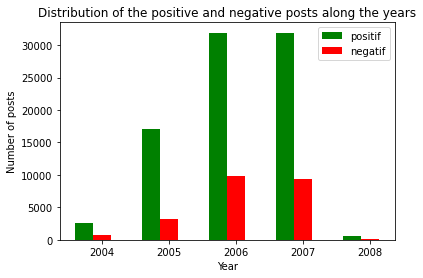

In [177]:
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

 
year_pos_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.year).size()
rects1 = ax.bar(ind, year_pos_wiki, width, color='g')
year_neg_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.year).size()
rects2 = ax.bar(ind+width, year_neg_wiki, width, color='r')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Year')
ax.set_title('Distribution of the positive and negative posts along the years')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('2004', '2005', '2006', '2007', '2008'))
ax.legend((rects1[0], rects2[0]), ('positif', 'negatif'))

plt.show()

**Analysis :**
- So here both the amount of positive votes is higher than the negative ones, but both seams to have the same evolution along the year. We have to compute the ratio to make sure. 

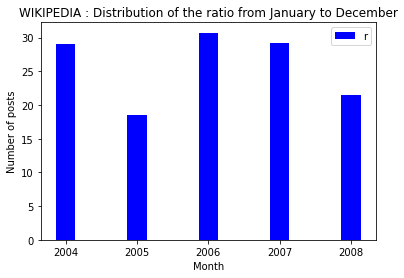

In [178]:
ratio_wiki = [(int(b) / int(m))*100 for b,m in zip(year_neg_wiki, year_pos_wiki)]
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)


rects1 = ax.bar(ind, ratio_wiki, width, color='b')
ax.set_ylabel('Number of posts')
ax.set_xlabel('Month')
ax.set_title('WIKIPEDIA : Distribution of the ratio from January to December')
ax.set_xticks(ind)
ax.set_xticklabels( ('2004', '2005', '2006', '2007', '2008'))
ax.legend('ratio neg/pos*100')

plt.show()

- so in 2005 the ratio neg/pos*100 is smaller than in 2006 and 2007. We can see on the previous graph that between 2004 and 2007 there is a huge increase of positive votes. 
- as we want to compare two different subgraphs based on year analysis, it is more intersting to take 2005 and 2007 as 2004 and 2007 have quite the same ratio (thus 2007 is an enlargement of the situation in 2004). 

**Ccl :** In order to assess the impact of the **HOUR** on the structure of the network, we can compare  3 subgraphs : 
> - from 2005 (representative of the first group - ratio  15-20- )
> - from 2007 (representative of the second group, -ratio 25-30-)
> - from 2008 (representative of the third group, -ration 20-25-)

#### Step 2 : Analysis of the month 

In [179]:
month_positive_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.month).size()
month_negative_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.month).size()
print('Month Positive', month_positive_wiki)
print('Month Negative', month_negative_wiki)

Month Positive Date
1     6610
2     5815
3     6766
4     6477
5     7760
6     6893
7     6438
8     5989
9     6353
10    8610
11    8748
12    7494
dtype: int64
Month Negative Date
1     2006
2     1605
3     1894
4     1857
5     2272
6     1830
7     2134
8     1818
9     1817
10    2279
11    1602
12    2004
dtype: int64


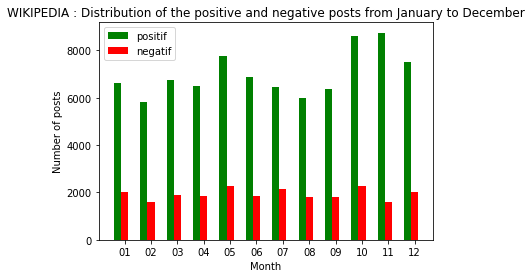

In [180]:
N = 12
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

 
month_pos_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.month).size()
rects1 = ax.bar(ind, month_pos_wiki, width, color='g')
month_neg_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.month).size()
rects2 = ax.bar(ind+width, month_neg_wiki, width, color='r')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Month')
ax.set_title('WIKIPEDIA : Distribution of the positive and negative posts from January to December')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'))
ax.legend( (rects1[0], rects2[0]), ('positif', 'negatif') )

plt.show()

**Analysis :**
- hard to see if pos and neg have the same trend, need to compute the ratio

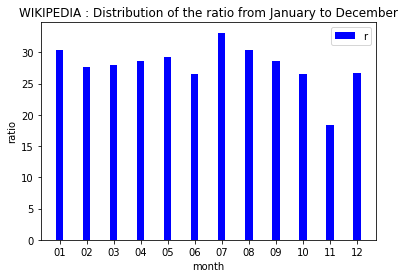

In [181]:
ratio_w = [(int(b) / int(m))*100 for b,m in zip(month_neg_wiki, month_pos_wiki)]
N = 12
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)


rects1 = ax.bar(ind, ratio_w, width, color='b')
ax.set_ylabel('ratio')
ax.set_xlabel('month')
ax.set_title('WIKIPEDIA : Distribution of the ratio from January to December')
ax.set_xticks(ind)
ax.set_xticklabels( ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'))
ax.legend('ratio neg/pos*100')

plt.show()

- three parts : small ratio : month 11, high ratio : month 7, middle ratio : month 1-2-3-4-5-6-8-9-10-12
- we have to find the more representative month for middle ratio

In [182]:
# ratio middle
mean_middle_pos = statistics.mean([month_pos_wiki.iloc[0], month_pos_wiki.iloc[1], month_pos_wiki.iloc[2], month_pos_wiki.iloc[3], month_pos_wiki.iloc[4], month_pos_wiki.iloc[5], month_pos_wiki.iloc[7], month_pos_wiki.iloc[10], month_pos_wiki.iloc[11]])
print('The mean count of posts from jan. to apr. is ', mean_middle_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_middle_pos) for x in[month_pos_wiki.iloc[0], month_pos_wiki.iloc[1], month_pos_wiki.iloc[2], month_pos_wiki.iloc[3], month_pos_wiki.iloc[4], month_pos_wiki.iloc[5], month_pos_wiki.iloc[7], month_pos_wiki.iloc[10], month_pos_wiki.iloc[11]]])

The mean count of posts from jan. to apr. is  6950
The difference between number of counts and mean for march and april is respectively: 
 [340, 1135, 184, 473, 810, 57, 961, 1798, 544]


- more representative for the middle ratio is june (06) because the difference with the average value is the smaller. 

**Ccl :** In order to assess the impact of the **MONTH** on the structure of the network, we can compare  3 subgraphs : 
> - from novembre (11) (representative of the first group - low ratio < 20- )
> - from july (07) (representative of the second group, -high ratio > 30-)
> - from june (06) (representative of the third group, -middle ratio around 25-)

#### Step 3 :  Analysis of the day 

In [183]:
day_positive_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.day).size()
day_negative_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.day).size()
print('Month Positive', day_positive_wiki)
print('Month Negative', day_negative_wiki)

Month Positive Date
1     3056
2     2906
3     2962
4     3107
5     3325
6     2930
7     2987
8     2934
9     2801
10    3194
11    2921
12    2772
13    2777
14    2790
15    2690
16    2643
17    2521
18    2509
19    2418
20    2569
21    2486
22    2686
23    2742
24    2754
25    2343
26    2504
27    2392
28    2669
29    2252
30    2479
31    1834
dtype: int64
Month Negative Date
1     845
2     915
3     851
4     825
5     789
6     860
7     800
8     808
9     842
10    795
11    701
12    693
13    761
14    621
15    608
16    732
17    667
18    699
19    634
20    643
21    726
22    763
23    854
24    755
25    650
26    672
27    696
28    733
29    839
30    781
31    560
dtype: int64


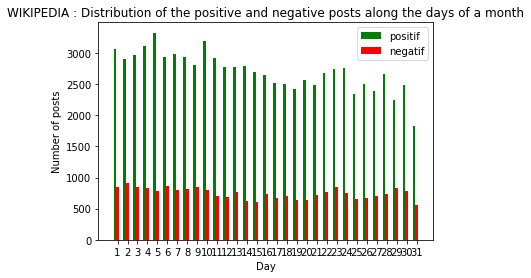

In [184]:
N = 31
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

 
day_pos_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.day).size()
rects1 = ax.bar(ind, day_pos_wiki, width, color='g')
day_neg_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.day).size()
rects2 = ax.bar(ind+width, day_neg_wiki, width, color='r')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Day')
ax.set_title('WIKIPEDIA : Distribution of the positive and negative posts along the days of a month')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26' ,'27', '28', '29', '30', '31'))
ax.legend((rects1[0], rects2[0]), ('positif', 'negatif'))

plt.show()

**Analysis :**
- compared to other graph, color red very present, it means that the ratio will probably be higher with this observation according to the day of the month 
- need to compute the ration to see overall trend

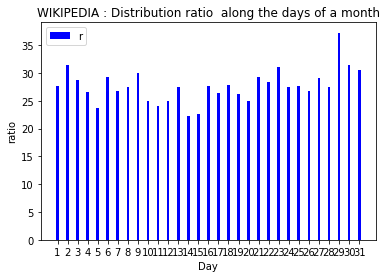

In [185]:
ratio_w = [(int(b) / int(m))*100 for b,m in zip(day_neg_wiki, day_pos_wiki)]
N = 31
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, ratio_w, width, color='b')

ax.set_ylabel('ratio')
ax.set_xlabel('Day')
ax.set_title('WIKIPEDIA : Distribution ratio  along the days of a month')
ax.set_xticks(ind)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26' ,'27', '28', '29', '30', '31'))
ax.legend('ratio')
plt.show()

- as for Reddit, the approach look at the day in a month not very clear, we focus on day of the week

In [186]:
day_positive_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.weekday).size()
day_negative_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.weekday).size()
print('Month Positive', day_positive_wiki)
print('Month Negative', day_negative_wiki)

Month Positive Date
0    12181
1    13259
2    12409
3    12257
4    12252
5    11081
6    10514
dtype: int64
Month Negative Date
0    3203
1    3513
2    3353
3    3488
4    3602
5    2827
6    3132
dtype: int64


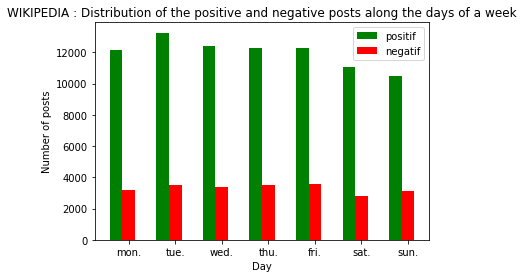

In [187]:
N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

 
dayw_pos_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.weekday).size()
rects1 = ax.bar(ind, dayw_pos_wiki, width, color='g')
dayw_neg_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.weekday).size()
rects2 = ax.bar(ind+width, dayw_neg_wiki, width, color='r')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Day')
ax.set_title('WIKIPEDIA : Distribution of the positive and negative posts along the days of a week')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('mon.', 'tue.', 'wed.', 'thu.', 'fri.', 'sat.', 'sun.'))
ax.legend((rects1[0], rects2[0]), ('positif', 'negatif'))

plt.show()

- As to compute the ratio

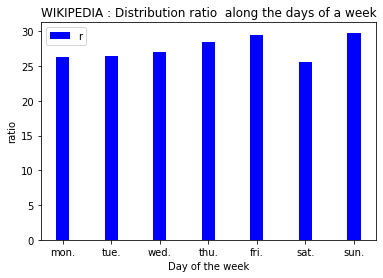

In [188]:
ratio_w = [(int(b) / int(m))*100 for b,m in zip(dayw_neg_wiki, dayw_pos_wiki)]
N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, ratio_w, width, color='b')

ax.set_ylabel('ratio')
ax.set_xlabel('Day of the week')
ax.set_title('WIKIPEDIA : Distribution ratio  along the days of a week')
ax.set_xticks(ind)
ax.set_xticklabels( ('mon.', 'tue.', 'wed.', 'thu.', 'fri.', 'sat.', 'sun.'))
ax.legend('ratio')
plt.show()

- increase during the work week (monday to friday) and different from saturday to sunday. Saturday looks like the beginning of the week while sunday looks like friday
- so we will focus on the extrem : monday and friday

**Ccl :** In order to assess the impact of the **MONTH** on the structure of the network, we can compare  3 subgraphs : 
> - from monday 
> - from friday

#### Step 4 : Analysis of the hour 

In [190]:
hour_positive_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.hour).size()
hour_negative_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.hour).size()
print('Month Positive', hour_positive_wiki)
print('Month Negative', hour_negative_wiki)

Month Positive Date
0     4784
1     4417
2     4196
3     3879
4     3597
5     3196
6     2821
7     2507
8     2400
9     2073
10    2290
11    2421
12    2539
13    2877
14    3215
15    3585
16    3784
17    3978
18    4067
19    3939
20    4144
21    4574
22    4313
23    4357
dtype: int64
Month Negative Date
0     1273
1     1173
2     1149
3     1081
4      952
5      913
6      767
7      713
8      595
9      544
10     555
11     548
12     686
13     778
14     887
15    1040
16    1047
17    1157
18    1183
19    1093
20    1175
21    1270
22    1302
23    1237
dtype: int64


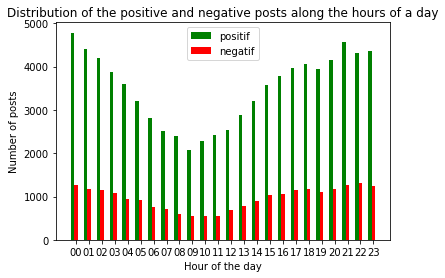

In [192]:
N = 24
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

hour_pos_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.hour).size()
rects1 = ax.bar(ind, hour_pos_wiki, width, color='g')
hour_neg_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.hour).size()
rects2 = ax.bar(ind+width, hour_neg_wiki, width, color='r')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Hour of the day')
ax.set_title('Distribution of the positive and negative posts along the hours of a day')
ax.set_xticks(ind+width)
ax.set_xticklabels(('00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))
ax.legend((rects1[0], rects2[0]), ('positif', 'negatif'))

plt.show()

**Analysis :**
- crazy trend :) It is to have very less vote at morning - mid day then during night ... (is it because of jetlag somehow??)
- both positive and negative seams to have the same trend, but positive seams to be more marked. Compute the ratio to check

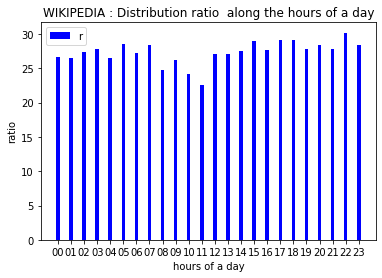

In [193]:
ratio_ww = [(int(b) / int(m))*100 for b,m in zip(hour_neg_wiki, hour_pos_wiki)]
N = 24
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, ratio_ww, width, color='b')

ax.set_ylabel('ratio')
ax.set_xlabel('hours of a day')
ax.set_title('WIKIPEDIA : Distribution ratio  along the hours of a day')
ax.set_xticks(ind)
ax.set_xticklabels(('00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))
ax.legend('ratio')
plt.show()

- kind of loosing the previous trend : so both positve and negative where behaving quite similar
- here 2 parts : low ratio (around morning : 8, 10, 11 and then middle one (00, 01, 02, 03, 04, 05, 06, 07, 09, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)

In [194]:
# ratio low 
mean_rlow_pos = statistics.mean([hour_pos.iloc[8], hour_pos.iloc[10], hour_pos.iloc[11]])
print('The mean count of posts from jan. to apr. is ', mean_rlow_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_rlow_pos) for x in[hour_pos.iloc[8], hour_pos.iloc[10], hour_pos.iloc[11]]])


The mean count of posts from jan. to apr. is  14149
The difference between number of counts and mean for march and april is respectively: 
 [777, 40, 738]


- 10h is representative of low ratio

In [195]:
# ratio middle 
mean_rmiddle_pos = statistics.mean([hour_pos.iloc[0], hour_pos.iloc[1], hour_pos.iloc[2], hour_pos.iloc[3], hour_pos.iloc[4], hour_pos.iloc[5], hour_pos.iloc[6], hour_pos.iloc[7], hour_pos.iloc[9], hour_pos.iloc[12], hour_pos.iloc[13], hour_pos.iloc[14], hour_pos.iloc[15], hour_pos.iloc[16], hour_pos.iloc[17], hour_pos.iloc[18], hour_pos.iloc[19], hour_pos.iloc[20], hour_pos.iloc[21], hour_pos.iloc[22], hour_pos.iloc[23]])
print('The mean count of posts from jan. to apr. is ', mean_rmiddle_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_rmiddle_pos) for x in[hour_pos.iloc[0], hour_pos.iloc[1], hour_pos.iloc[2], hour_pos.iloc[3], hour_pos.iloc[4], hour_pos.iloc[5], hour_pos.iloc[6], hour_pos.iloc[7], hour_pos.iloc[9], hour_pos.iloc[12], hour_pos.iloc[13], hour_pos.iloc[14], hour_pos.iloc[15], hour_pos.iloc[16], hour_pos.iloc[17], hour_pos.iloc[18], hour_pos.iloc[19], hour_pos.iloc[20], hour_pos.iloc[21], hour_pos.iloc[22], hour_pos.iloc[23]]])


The mean count of posts from jan. to apr. is  10621
The difference between number of counts and mean for march and april is respectively: 
 [3532, 4576, 4987, 4521, 3754, 2802, 683, 1448, 3805, 3950, 3996, 4373, 3528, 2646, 2546, 1797, 1268, 304, 721, 1687, 2396]


- 6h is representative of the middle ratio

**Ccl :** In order to assess the impact of the **MONTH** on the structure of the network, we can compare  3 subgraphs : 
> - from 10h 
> - from 6h

### Structural analysis on wikipedia subgraphs

Then let’s have a look on the wikipedia dataset.
 Three subgraphs have been computed from this dataset according to the year global trend. One from 2005, representing the ratio 15-20 group, one from 2007 representing the 25-30 ratio group and the third one from 2008 representing the 20-25 ratio group.

Here are presented the parameters for the centrality analysis : so degree, closeness, local clustering coefficient and of course centrality degree. As these parameters are calculated for a single node, we are presenting here the min, max and average in the total network.


#### Wikipedia - Year 

In [248]:
Wiki_votes

,FromNodeId,ToNodeId,Sign,Date
0,3,30,1,2004-09-14 16:26:00
1,25,30,-1,2004-09-14 16:53:00
2,4,30,1,2004-09-14 17:08:00
3,5,30,1,2004-09-14 17:37:00
4,6,30,1,2004-09-14 19:28:00
...,...,...,...,...
107075,8045,6307,-1,2008-01-05 23:34:00
107076,7053,6307,-1,2008-01-05 23:36:00
107077,6885,6307,-1,2008-01-06 00:44:00
107078,8243,6307,-1,2008-01-06 01:07:00


In [249]:
mask_2005 = (Wiki_votes['Date'] > '2005-1-1') & (Wiki_votes['Date'] <= '2005-12-31')
mask_2007 = (Wiki_votes['Date'] > '2007-1-1') & (Wiki_votes['Date'] <= '2007-12-31')
mask_2008 = (Wiki_votes['Date'] > '2008-1-1') & (Wiki_votes['Date'] <= '2008-12-31')

wikipedia_2005 = Wiki_votes.loc[mask_2005]
wikipedia_2007 = Wiki_votes.loc[mask_2007]
wikipedia_2008 = Wiki_votes.loc[mask_2008]

In [250]:
wikipedia_2007.head()

,FromNodeId,ToNodeId,Sign,Date
3370,625,624,1,2007-02-20 00:47:00
7091,1004,789,1,2007-04-12 23:16:00
33734,3194,3195,-1,2007-08-14 16:01:00
33943,3224,2237,-1,2007-07-10 13:06:00
42745,3794,3797,1,2007-01-06 21:49:00


In [251]:
wikipedia_2005.head()

,FromNodeId,ToNodeId,Sign,Date
404,165,167,-1,2005-01-31 13:01:00
1149,304,322,1,2005-05-24 20:28:00
1150,72,322,1,2005-05-24 20:39:00
1151,94,322,-1,2005-05-24 21:20:00
1152,25,322,-1,2005-05-24 21:59:00


In [252]:
wikipedia_2005_graph = nx.from_pandas_edgelist(wikipedia_2005,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_2008_graph = nx.from_pandas_edgelist(wikipedia_2008,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_2007_graph = nx.from_pandas_edgelist(wikipedia_2007,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_2005_table1,wikipedia_2005_table2,wikipedia_2005_table3 = graph_properties(wikipedia_2005_graph)
wikipedia_2007_table1,wikipedia_2007_table2,wikipedia_2007_table3 = graph_properties(wikipedia_2007_graph)
wikipedia_2008_table1,wikipedia_2008_table2,wikipedia_2008_table3 = graph_properties(wikipedia_2008_graph)

In [253]:
wikipedia_2005_table1

,Average,Max,Min
Degree,20.407061,422.000000,1.000000
Closeness,0.067255,0.304447,0.000000
Local clustering coefficient,0.078754,1.000000,0.000000
Centrality,0.010601,0.219221,0.000519


In [254]:
wikipedia_2007_table1

,Average,Max,Min
Degree,21.853923,533.000000,1.000000
Closeness,0.057548,0.316734,0.000000
Local clustering coefficient,0.074431,1.000000,0.000000
Centrality,0.005935,0.144758,0.000272


In [255]:
wikipedia_2008_table1

,Average,Max,Min
Degree,4.291667,114.000000,1.000000
Closeness,0.010002,0.413115,0.000000
Local clustering coefficient,0.062715,1.000000,0.000000
Centrality,0.014954,0.397213,0.003484


First 2005 and 2007 have pretty similar average node degrees while 2008 have a very smaller one. All the three have a minimum node degree of 1 which means that there is no isolated node. 
**Axel** : do you agree ? 

However both 2005 and 2008 have a similar average centrality value, while 2007 has a very lower one (factor 2). This means that there is a dissymmetry in the network structure between the years. A high average degree means that nodes tend to have a lot of incoming edges, and a high value of centrality means that nodes tend to have a high number of connections (in total both incoming and outgoing).So in the case of 2008, the high average centrality means a lot of connection per for each node. The quite low average degree is pretty surprising but could mean a disequilibrium of the sent and received number of edges.

we can see that the closeness average is 6 or 5 times smaller for 2008 than for 2005 and 2007. A small average closeness indicates an important average distance between a node with all the nodes. This could mean that the nodes tend to be linked to more distant ones. 

All the subgraphs seem to have the same clustering coefficient, and thus neighbors of a random node seem to be equally connected.

-----------


Now let’s have a look at the behaviour and clustering analysis. 


In [256]:
wikipedia_2005_table2

,
Global clustering coefficient,0.062375
Assortativity degree,-0.110852
Number of triads,88438.000000


In [257]:
wikipedia_2007_table2

,
Global clustering coefficient,0.061274
Assortativity degree,-0.153825
Number of triads,231341.000000


In [258]:
wikipedia_2008_table2

,
Global clustering coefficient,0.120192
Assortativity degree,-0.178545
Number of triads,226.000000


First we can see that the global clustering coefficient is the highest for 2008, compared to 2007 which is itself higher than 2005. This is in accordance with our previous observations about the high connectivity of this network.  We could also interpret this high global clustering coefficient as a bigger probability to have an edge between two nodes with a common neighbor, because its means a higher proportion of triangles in the graph.
For the assortativity degree, we do not see a particular trend along the 3 years. 


-----

Then we have a look at the proportion of triad types. 


In [259]:
wikipedia_2005_table3

,Triads
+++,72215
++-,10924
+--,4819
---,480


In [260]:
wikipedia_2007_table3

,Triads
+++,163849
++-,47615
+--,17099
---,2778


In [261]:
wikipedia_2008_table3

,Triads
+++,199
++-,20
+--,7
---,0



Here we are able to see changes in the network structure according to the year, especially concerning the clustering. In fact the year 2008 appears to be more tightly connected than the 2005 and 2007. It is quite important to notice this in the context of votation because it changes the possible consequences of an event at one part of the network on the final output. As population mass manipulation if you are nominated, it is very important to know this in order to assess the impact of your choice of campaign.
These results are not aberrant in our connected world, where everyone tends to be more and more connected, even to people away (geographically, socially, culturally).
However, these results are not obvious and further computation should be done. Here it is just an highlighting of the possible impact on the structure, to raise conscientiousness about this variable.



#### Wikipedia - Month 

So now we are considering time trends according to the month. 


In [218]:
mask_nov = (Wiki_votes['Date'].dt.month == 11)
mask_july = (Wiki_votes['Date'].dt.month == 7)
mask_june = (Wiki_votes['Date'].dt.month == 6)

wikipedia_nov = Wiki_votes.loc[mask_nov]
wikipedia_july = Wiki_votes.loc[mask_july]
wikipedia_june = Wiki_votes.loc[mask_june]

In [219]:
wikipedia_july.head(20000)

,FromNodeId,ToNodeId,Sign,Date
2106,453,192,1,2004-07-11 00:23:00
2107,18,192,-1,2004-07-11 00:37:00
2108,101,192,-1,2004-07-11 00:38:00
2109,352,192,-1,2004-07-11 00:43:00
2110,56,192,1,2004-07-11 00:46:00
...,...,...,...,...
90764,1549,5288,1,2007-07-31 22:45:00
90765,4795,5288,1,2007-07-31 22:53:00
90766,4455,5288,1,2007-07-31 23:23:00
90767,737,5288,1,2007-07-31 23:41:00


In [220]:
wikipedia_nov_graph = nx.from_pandas_edgelist(wikipedia_nov,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_july_graph = nx.from_pandas_edgelist(wikipedia_july,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_june_graph = nx.from_pandas_edgelist(wikipedia_june,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_nov_table1,wikipedia_nov_table2,wikipedia_nov_table3 = graph_properties(wikipedia_nov_graph)
wikipedia_july_table1,wikipedia_july_table2,wikipedia_july_table3 = graph_properties(wikipedia_july_graph)
wikipedia_june_table1,wikipedia_june_table2,wikipedia_june_table3 = graph_properties(wikipedia_june_graph)

Let’s have a look on the wikipedia dataset. As a reminder, we splitted the data according to 3 ratio neg/pos edges different. The first part is from november and represent the group with low ratio (not a lot of neg edges), the second part is from june and represent the group with middle ratio (quite the same amount of  pos and neg edges) and finally the third one is from july and represent the group with a high ratio (quite a lot  of negative edges). 
Here are presented the results for centrality parameters. We can see : 
The average degree value is quite the same for all the 3 months 
The closeness average value is also quite constant among the 3 months 
The local clustering coefficient is rising according to the proportion of negative edges. This means that it is small in november, higher in june and even higher in july (which has the biggest ratio). Even if it is hard to do a guess about why do we see a such trend, the arrival of the summer and holidays may have a link with people's activity and thus their amount of connections to each other. In fact a higher local clustering coefficient means that the removal of a given node will have less impact on the ability of communication of influence of its neighbor. It is quite important to notice that during votation process because it means on the other side that during winter (e.g. november), node’s communication/influence are more dependant to each other and thus individual position-taking can have a big consequences, and its nature -an opposite leader or a supporter- may become important.
The centrality coefficient is a bit higher in june compared to other ones, but as for the closeness, the difference may not be big enough to allow any conclusions


In [221]:
wikipedia_nov_table1

,Average,Max,Min
Degree,10.051506,189.000000,1.000000
Closeness,0.016710,0.253044,0.000000
Local clustering coefficient,0.058889,1.000000,0.000000
Centrality,0.004886,0.091881,0.000486


In [222]:
wikipedia_july_table1

,Average,Max,Min
Degree,9.592821,244.000000,1.000000
Closeness,0.021830,0.287275,0.000000
Local clustering coefficient,0.086298,1.000000,0.000000
Centrality,0.005383,0.136925,0.000561


In [223]:
wikipedia_june_table1

,Average,Max,Min
Degree,10.283019,186.000000,1.00000
Closeness,0.018842,0.234398,0.00000
Local clustering coefficient,0.078658,1.000000,0.00000
Centrality,0.006067,0.109735,0.00059


------

Now let’s have a look at the clustering and behavior parameters

In [224]:
wikipedia_nov_table2

,
Global clustering coefficient,0.061379
Assortativity degree,-0.078402
Number of triads,12531.000000


In [225]:
wikipedia_june_table2

,
Global clustering coefficient,0.093659
Assortativity degree,-0.059507
Number of triads,14723.000000


In [226]:
wikipedia_july_table2

,
Global clustering coefficient,0.098919
Assortativity degree,-0.100510
Number of triads,14680.000000


The global clustering coefficient is higher in summer (june - july) than in winter (november). It means that nodes tend to create more close triangles during summer than winter. As the local clustering coefficient, this trend may be explained by the atmosphere of the summer, and the rise of activating associated. What we can say is that the summer months present a network more connected. 
The assortativity doesn't have a very clear global trend. We can only say that July is the closest one to zero, which means that it tends to be more non-assortative and November and even more July tend to be more disassortative. It is quite hard to explain these observations. 


------

Let’s have a look on the triads type proportions. 


In [227]:
wikipedia_nov_table3

,Triads
+++,10032
++-,1913
+--,516
---,70


In [228]:
wikipedia_july_table3

,Triads
+++,10211
++-,2870
+--,1388
---,211


In [229]:
wikipedia_june_table3

,Triads
+++,11579
++-,2193
+--,846
---,105


Conclusion
It is quite hard to explain all the trends, sometimes quite small or illogical. However these observations and understanding could be important in a votation process because as we have seen that may have an impact on the global structure of the network. With the local clustering coefficient, we have seen that the network tends to be more influenceable in winter than in summer, thus political calculations may take it into account. Also it appears that the summer network tends to be more connected, so with more closed triangles than in winter. Thus people are more connected and as they are influencing each other, the strategy of communication of a candidate may change (could focus on a group of people, because they tend to be more connected than patchy ones in the winter where it would be more difficult to talk to a group). Finally, even if the trend is not very logical, assortativity may give important information on the network structure. November and July seem to be more diss-assortative, thus it means that links between nodes are not very similar. So for a candidate talking to a group, it is important to have conscious of this, an adapt its speech : it would be perhaps more nuanced than if all people were similar, because its aim is to gather as many people as possible, so not to offend/ hurt or shock any part of the listening assembly.


#### Wikipedia - Day 

In [230]:
mask_monday = (Wiki_votes['Date'].dt.weekday == 0)
mask_friday = (Wiki_votes['Date'].dt.weekday == 4)

wikipedia_monday = Wiki_votes.loc[mask_monday]
wikipedia_friday = Wiki_votes.loc[mask_friday]

In [231]:
wikipedia_monday_graph = nx.from_pandas_edgelist(wikipedia_monday,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_friday_graph = nx.from_pandas_edgelist(wikipedia_friday,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)


wikipedia_monday_table1,wikipedia_monday_table2,wikipedia_monday_table3 = graph_properties(wikipedia_monday_graph)
wikipedia_friday_table1,wikipedia_friday_table2,wikipedia_friday_table3 = graph_properties(wikipedia_friday_graph)

Now we are going to focus on the influence of the weekday on the voting behavior. As a reminder, we have created 2 subgraphs according to the trend observed along the week. We have seen that the ratio neg/pos is becoming more important along the workweek, and that during the week-end, saturday looks like monday and sunday looks like friday. With very basic psychology, one interpretation would be that along the week people are getting more and more tired and are generally fed up. On saturday it is the beginning of the weekend, so people are more happy and then tend to vote less negatively, while on sunday it is the end of the weekend, so people are sad and annoyed by the situation. This try of explanation is based on the idea that people’s mood influences the vote. To be more precise in the analysis of trend’s observations we would need to go further in social analysis/explanation, but we are not competent here. Anyway, this trial of explanation can give an idea. 
So here we have chosen to build a subgraph from votes on monday, representing the low ratio of the beginning of the week (and saturday, people happy?), and one from friday, representing the end of workweek and sunday (people fed up?). 
Let’s have a look at the centrality parameters first.


In [232]:
wikipedia_monday_table1

,Average,Max,Min
Degree,8.846087,166.000000,1.000000
Closeness,0.047316,0.179846,0.000000
Local clustering coefficient,0.017640,1.000000,0.000000
Centrality,0.002555,0.047949,0.000289


In [233]:
wikipedia_friday_table1

,Average,Max,Min
Degree,8.909245,233.000000,1.000000
Closeness,0.047259,0.197214,0.000000
Local clustering coefficient,0.019541,0.500000,0.000000
Centrality,0.002520,0.065894,0.000283


----------

In [234]:
wikipedia_monday_table2

,
Global clustering coefficient,0.017420
Assortativity degree,-0.015305
Number of triads,6062.000000


In [235]:
wikipedia_friday_table2

,
Global clustering coefficient,0.019813
Assortativity degree,-0.012944
Number of triads,7406.000000


-----

In [236]:
wikipedia_monday_table3

,Triads
+++,4264
++-,1197
+--,530
---,71


In [237]:
wikipedia_friday_table3

,Triads
+++,5203
++-,1375
+--,696
---,132


#### Wikipedia - Hour

Now we focus on the hour of the day. After plotting the ratio of neg/pos edges according to the hour of the day, we were able to identify 2 groups. We have drawn a first subgraph from 10h, representing the group with low ratio, and a second one from 6h representative from the high ratio. As we were able to see on the graph of the ratio, lower one corresponds to the mid-day period, while higher one corresponds to the afternoon/night and morning period. One could understand it during the lunch break, people tend to be more happy and thus vote less negatively. Of course it is only an hypothesis, but it can give an idea. 
Let’s have a look at the centrality parameters. 


In [238]:
mask_10h = (Wiki_votes['Date'].dt.hour == 10)
mask_6h = (Wiki_votes['Date'].dt.hour == 6)

wikipedia_10h = Wiki_votes.loc[mask_10h]
wikipedia_6h = Wiki_votes.loc[mask_6h]

In [239]:
wikipedia_6h.head()

,FromNodeId,ToNodeId,Sign,Date
10,12,30,1,2004-09-15 06:56:00
68,11,61,1,2004-09-12 06:21:00
84,27,6,1,2004-09-11 06:13:00
85,11,6,1,2004-09-11 06:50:00
128,12,8,-1,2004-09-15 06:38:00


In [240]:
wikipedia_10h.head()

,FromNodeId,ToNodeId,Sign,Date
50,47,54,1,2004-09-16 10:28:00
51,48,54,1,2004-09-16 10:39:00
55,50,54,1,2004-09-17 10:47:00
75,14,61,1,2004-09-13 10:22:00
137,45,8,-1,2004-09-16 10:08:00


In [241]:
wikipedia_10h_graph = nx.from_pandas_edgelist(wikipedia_10h,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_6h_graph = nx.from_pandas_edgelist(wikipedia_6h,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)


wikipedia_10h_table1,wikipedia_10h_table2,wikipedia_10h_table3 = graph_properties(wikipedia_10h_graph)
wikipedia_6h_table1,wikipedia_6h_table2,wikipedia_6h_table3 = graph_properties(wikipedia_6h_graph)

In [242]:
wikipedia_10h_table1

,Average,Max,Min
Degree,3.057558,82.000000,1.000000
Closeness,0.002978,0.027898,0.000000
Local clustering coefficient,0.005650,0.500000,0.000000
Centrality,0.001646,0.044133,0.000538


In [243]:
wikipedia_6h_table1

,Average,Max,Min
Degree,3.427887,63.000000,1.000000
Closeness,0.005022,0.036394,0.000000
Local clustering coefficient,0.004731,0.500000,0.000000
Centrality,0.001643,0.030201,0.000479


we can see : 
The degree average looks the same for both 10h and 6h. However the range of possible values is bigger at 10h than at 6h, but as it is deeply linked with the size of the sample, we have to be careful on these observations. 
The closeness is small for both, but higher at 6h then at 10h so the network in the morning/afternoon may be more edge-sensitize (affected quickly for an event on another part of the network) than at mid-day
The local clustering coefficient is also very similar, the small difference doesn’t allow use to draw any conclusions
The centrality is also very similar
For now we can say that both subgraphs are quite similar according to centrality parameters. Let’s have a look at behavior and clustering ones. 


------

In [244]:
wikipedia_10h_table2

,
Global clustering coefficient,0.002137
Assortativity degree,-0.099332
Number of triads,66.000000


In [245]:
wikipedia_6h_table2

,
Global clustering coefficient,0.002967
Assortativity degree,-0.088337
Number of triads,98.000000


Behavior and clustering parameters. We can see : 
Both global clustering and assortativity values are really similar for 6 and 10h. There is a slight increase in global clustering coefficient for 6h and a small diminution of assortativity degree. That may mean that the nodes are less aggregated to similar ones and that they tend to form more triangles. Thus the network at 6h would be more connected, and with more heterogeneous groups than at 10h. 
However these differences are so small that we would need further analysis to be able to assess this conclusion. Here it is just to raise curiosity about this trend, and there is a cue that something could be impacted.


-----

In [246]:
wikipedia_10h_table3

,Triads
+++,38
++-,18
+--,9
---,1


In [247]:
wikipedia_6h_table3

,Triads
+++,60
++-,27
+--,9
---,2


Conclusion : 
So here we have analysed the possible impact of the hour on the voting network structure of wikipedia. As we were able to see comparing the different parameters between the 6h and 10h subgraphs, the differences are very very small and don’t allow us to draw sure conclusions. We could say that hour of the day may not influence the network structure that much and thus doesn’t need to be taken into account in network structure analysis. 
We had to do this analysis to carefully say this. However, further analysis is needed to properly exclude this variable from the group of network structure influencing ones.


#5) Weights 


In [264]:
sentiment = data_body['PROPERTIES'].apply(lambda x: x.split(','))
data_body['Sentiment'] = sentiment.apply(lambda x: float(x[20]))

In [265]:
negtive_sentiment = (data_body['Sentiment'] < 0)
positive_sentiment = (data_body['Sentiment'] >= 0)

data_body_neg_sentiment = data_body.loc[negtive_sentiment]
data_body_pos_sentiment = data_body.loc[positive_sentiment]

In [266]:
data_body_neg_sentiment

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES,Sentiment
13,suicidewatch,offmychest,1u5k33s,2014-01-01 03:01:53,1,"183.0,162.0,0.75956284153,0.0109289617486,0.03...",-0.5008
19,tribes,games,1u5syks,2014-01-01 09:06:30,1,"1316.0,1108.0,0.788753799392,0.00303951367781,...",-0.8319
23,corejerk,bestof2013,1u5w42s,2014-01-01 04:58:04,1,"2735.0,2451.0,0.722120658135,0.0197440585009,0...",-0.2869
26,thedoctorstravels,hungergamesrp,1u638cs,2014-01-01 10:08:48,1,"201.0,181.0,0.766169154229,0.0149253731343,0.0...",-0.1685
37,civcraft,leningrad,1u6iw5s,2014-01-01 14:01:28,1,"1096.0,930.0,0.797445255474,0.00547445255474,0...",-0.9652
...,...,...,...,...,...,...,...
286554,subredditdrama,funny,68iigy,2017-04-30 16:05:45,-1,"345.0,305.0,0.747826086957,0.0173913043478,0.0...",-0.6705
286555,negareddit,cringeanarchy,68im20s,2017-04-30 16:31:26,1,"441.0,405.0,0.775510204082,0.0294784580499,0.0...",-0.2593
286556,negareddit,debatefascism,68im20s,2017-04-30 16:31:26,1,"441.0,405.0,0.775510204082,0.0294784580499,0.0...",-0.2593
286557,mildlynomil,justnomil,68imlas,2017-04-30 04:19:03,1,"2226.0,1855.0,0.786163522013,0.00224618149146,...",-0.9726


In [267]:
data_body_pos_sentiment

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES,Sentiment
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08...",0.1748
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049...",0.5538
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082...",0.0000
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0....",0.9672
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0....",0.8906
...,...,...,...,...,...,...,...
286551,swart,summonerswar,68igk8s,2017-04-29 18:54:37,1,"9817.0,8070.0,0.777325048385,0.000916777019456...",0.9976
286552,skincareexchange,asianbeautyexchange,68ignes,2017-04-30 15:01:04,1,"590.0,520.0,0.703389830508,0.0457627118644,0.0...",0.4019
286553,weedstocks,wallstreetbets,68ihozs,2017-04-30 14:28:25,1,"870.0,748.0,0.766666666667,0.00459770114943,0....",0.9274
286558,mmorpg,blackdesertonline,68ip5os,2017-04-30 16:54:08,1,"1100.0,909.0,0.778181818182,0.00181818181818,0...",0.6052


In [268]:
import networkx as nx 

reddit_pos_sentiment_graph = nx.from_pandas_edgelist(data_body_pos_sentiment,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_neg_sentiment_graph= nx.from_pandas_edgelist(data_body_neg_sentiment,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)


In [270]:
reddit_pos_sentiment_table1,reddit_pos_sentiment_table2,reddit_pos_sentiment_table3 = graph_properties(reddit_pos_sentiment_graph) #,data_body_pos_sentiment["Sentiment"])
reddit_neg_sentiment_table1,reddit_neg_sentiment_table2,reddit_neg_sentiment_table3 = graph_properties(reddit_neg_sentiment_graph) #,data_body_pos_sentiment["Sentiment"])

In [271]:
reddit_pos_sentiment_table1

,Average,Max,Min
Degree,6.919743,2133.000000,1.000000
Closeness,0.083344,0.303221,0.000000
Local clustering coefficient,0.128603,1.000000,0.000000
Centrality,0.000214,0.065843,0.000031


In [272]:
reddit_neg_sentiment_table1

,Average,Max,Min
Degree,5.744742,1127.000000,1.000000
Closeness,0.065195,0.244835,0.000000
Local clustering coefficient,0.091463,1.000000,0.000000
Centrality,0.000391,0.076719,0.000068


In [273]:
reddit_pos_sentiment_table2

,
Global clustering coefficient,0.056951
Assortativity degree,-0.072501
Number of triads,434450.000000


In [274]:
reddit_neg_sentiment_table2

,
Global clustering coefficient,0.050851
Assortativity degree,-0.083903
Number of triads,162694.000000


In [275]:
reddit_pos_sentiment_table3

,Triads
+++,349631
++-,73868
+--,10317
---,634


In [276]:
reddit_pos_sentiment_table3

,Triads
+++,349631
++-,73868
+--,10317
---,634


## General question -----------------------------------------------------------------------------------------------

Do you agree to define the subsets according to the ratio or do you want to divid the subsets according to the size of the sample (so the number of posts-votes for a given day/hour/year)? 

## ---------------------------------------------------------------------------------------------------------------------------

- the most representative is 18h

In [ ]:
# ratio 9
mean_r9_pos = statistics.mean([hour_pos.iloc[9], hour_pos.iloc[11], hour_pos.iloc[14]])
print('The mean count of posts from jan. to apr. is ', mean_r9_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_r9_pos) for x in [hour_pos.iloc[9], hour_pos.iloc[11], hour_pos.iloc[14]]])

- the most representative is 12h

**Ccl :** In order to assess the impact of the **HOUR** on the structure of the network, we can compare  3 subgraphs : 
> - from 7h (representative of the first group - ratio 5-7 -)
> - from 18h (representative of the second group, -ratio 8-)
> - from 12h (representative of the third group, -ration 9-)

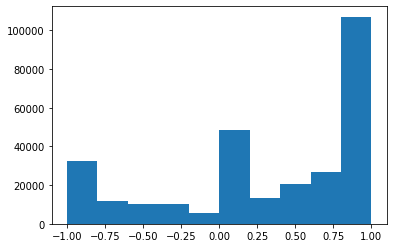

In [290]:

fig = plt.figure()
plt.hist(data_body['Sentiment'].tolist())
plt.show()

Out of the information about the distribution in the histogram, three subgraphs will be formed for further analyses. These three will represent one with a low sentiment score, mean sentiment score, and high sentiment score. 

By looking at the histogram we can see that a large number of the post have a score between -1.00 and -0.875, thus this will represent the subgraph with a low sentiment score. At the same time, one can see a large number of posts with a sentiment score between 0 and 0.125. That will represent the middle number. Lastly one can see that the score between 0.875 and 1 includes a very large number of posts, therefore this will be used as representing the subgraph with a high score. 



In [294]:
mask_low_sentiment = (data_body['Sentiment'] >= -1) & (data_body['Sentiment'] <= -0.875)
mask_middle_sentiment = (data_body['Sentiment'] >= 0) & (data_body['Sentiment'] <= 0.125)
mask_high_sentiment = (data_body['Sentiment'] <= 1) & (data_body['Sentiment'] >= 0.875)

reddit_low_sentiment = data_body.loc[mask_low_sentiment]
reddit_middle_sentiment = data_body.loc[mask_middle_sentiment]
reddit_high_sentiment = data_body.loc[mask_high_sentiment]

In [298]:
reddit_low_sentiment_graph = nx.from_pandas_edgelist(reddit_low_sentiment,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_middle_sentiment_graph= nx.from_pandas_edgelist(reddit_middle_sentiment,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_high_sentiment_graph= nx.from_pandas_edgelist(reddit_high_sentiment,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)


In [299]:
reddit_low_sentiment_table1,reddit_low_sentiment_table2,reddit_low_sentiment_table3 = graph_properties(reddit_low_sentiment_graph) 
reddit_middle_sentiment_table1,reddit_middle_sentiment_table2,reddit_middle_sentiment_table3 = graph_properties(reddit_middle_sentiment_graph) 
reddit_high_sentiment_table1,reddit_high_sentiment_table2,reddit_high_sentiment_table3 = graph_properties(reddit_high_sentiment_graph) 

In [300]:
reddit_low_sentiment_table1

,Average,Max,Min
Degree,4.594022,609.000000,1.000000
Closeness,0.045287,0.180528,0.000000
Local clustering coefficient,0.073576,1.000000,0.000000
Centrality,0.000616,0.081635,0.000134


In [301]:
reddit_middle_sentiment_table1

,Average,Max,Min
Degree,4.276664,976.000000,1.000000
Closeness,0.043907,0.222027,0.000000
Local clustering coefficient,0.054479,1.000000,0.000000
Centrality,0.000311,0.070915,0.000073


In [302]:
reddit_high_sentiment_table1

,Average,Max,Min
Degree,5.259896,787.000000,1.00000
Closeness,0.069383,0.253256,0.00000
Local clustering coefficient,0.111606,1.000000,0.00000
Centrality,0.000263,0.039336,0.00005


------

In [303]:
reddit_low_sentiment_table2

,
Global clustering coefficient,0.032196
Assortativity degree,-0.094474
Number of triads,30015.000000


In [304]:
reddit_middle_sentiment_table2

,
Global clustering coefficient,0.030376
Assortativity degree,-0.095623
Number of triads,38006.000000


In [305]:
reddit_high_sentiment_table2

,
Global clustering coefficient,0.048057
Assortativity degree,-0.062167
Number of triads,87649.000000


-----

In [306]:
reddit_low_sentiment_table3

,Triads
+++,11813
++-,11877
+--,5380
---,945


In [307]:
reddit_middle_sentiment_table3

,Triads
+++,26873
++-,9295
+--,1707
---,131


In [308]:
reddit_high_sentiment_table3

,Triads
+++,75885
++-,10386
+--,1316
---,62
